## Load Packages

In [170]:
pip install python-levenshtein

     |████████████████████████████████| 48 kB 589 kB/s eta 0:00:01
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.0-cp38-cp38-macosx_10_9_x86_64.whl size=76619 sha256=4a5bc511248b1f6ba5c1ba0f0b792a8e775669c10bdb34fa948ca37d3b819cc5
  Stored in directory: /Users/jiahuili/Library/Caches/pip/wheels/a8/da/22/2970e270912ba623ccac7d516b7411a820c8f2b4252463a605
Successfully built python-levenshtein
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import os
jp = os.path.join
import numpy as np
import pandas as pd
import json
import datetime

## Create a bucket

In [2]:
! aws s3 mb s3://jiahuili-msa8650  

make_bucket: jiahuili-msa8650


In [4]:
s3 = boto3.client('s3')
s3_bucket = 'jiahuili-msa8650'
s3_prefix = 'lpr-assignment/tmp'

In [5]:
# define path to local data directory
DATAPATH = "project_OCR" 

In [3]:
# Retrieve the list of existing buckets
s3 = boto3.client('s3')
response = s3.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  aws-glue-scripts-986515502727-us-east-2
  aws-glue-temporary-986515502727-us-east-2
  aws-machine-learning-jiahui
  jiahuili-msa8650


## Load images

In [6]:
ir_images = list(map(
    lambda f: f.strip(),
    os.popen(f"ls {jp(DATAPATH, 'ir_patch')}/*.jpg").readlines()
))
print(f"Number of IR images: {len(ir_images):,}")

Number of IR images: 1,821


In [8]:
# Set path to data files, inside DATAPATH should be the ir_patch folder
DATAPATH = "project_OCR"

# Amazon S3 client
s3 = boto3.client('s3')
s3_bucket = 'jiahuili-msa8650'
s3_prefix = 'lpr-assignment/tmp'

# Amazon Rekognition client
reko = boto3.client('rekognition')

T_0_loop = datetime.datetime.now()

cnt = 0
for i, fn in enumerate(ir_images):
    if i%100 == 0:
        print(f"{i:,}\t{fn}")
    
    # create filename for results
    res_fn = jp(
                DATAPATH,
                'amazon_rekognition',
                os.path.basename(fn).replace('ir_patch', 'amazon_rekognition').replace('.jpg', '.json')
    )
    
    if not os.path.exists(res_fn):
        cnt += 1
        T_0 = datetime.datetime.now()
        
        # upload image file to S3
        s3.upload_file(fn, s3_bucket, jp(s3_prefix, 'tmp_ir_path.jpg'))

        # call Amazon Rekognition
        response = reko.detect_text(Image={'S3Object':{'Bucket':s3_bucket, 'Name': jp(s3_prefix, 'tmp_ir_path.jpg')}})
        if response['ResponseMetadata']['HTTPStatusCode'] != 200:
            print(f"Rekognition failed:\n")
            pprint.pprint(response)
            break

        response['ProcessingTime'] = str(datetime.datetime.now() - T_0)
        with open(res_fn, 'w') as io:
            json.dump(response, io)
            
print(f"\n\nDone. Number of images processed: {cnt:,}  Total time: {datetime.datetime.now() - T_0_loop}")

0	project_OCR/ir_patch/14134_19700101194928245_BHA6172_1_ir_patch.jpg
100	project_OCR/ir_patch/14264_19700101121843079_CAY9621_1_ir_patch.jpg
200	project_OCR/ir_patch/14387_19700101135914931_PYW8543_1_ir_patch.jpg
300	project_OCR/ir_patch/14511_19700101191607559_BMD3363_1_ir_patch.jpg
400	project_OCR/ir_patch/14633_19700101113340173_PEV8894_1_ir_patch.jpg
500	project_OCR/ir_patch/14749_19700101130318095_PNT2817_1_ir_patch.jpg
600	project_OCR/ir_patch/14985_19700101182653117_PNU6081_1_ir_patch.jpg
700	project_OCR/ir_patch/15109_19700101221730832_PVE3685_1_ir_patch.jpg
800	project_OCR/ir_patch/15285_19700101115249476_AAA7863_1_ir_patch.jpg
900	project_OCR/ir_patch/15421_19700101132658396_PAA3532_1_ir_patch.jpg
1,000	project_OCR/ir_patch/15550_19700101184427670_AEX1024_1_ir_patch.jpg
1,100	project_OCR/ir_patch/15672_19700101221131205_PJV9626_1_ir_patch.jpg
1,200	project_OCR/ir_patch/15884_19700101120507517_L08_1_ir_patch.jpg
1,300	project_OCR/ir_patch/16019_19700101135017886_PB2245_1_ir_p

## View Results

In [6]:
ls -l project_OCR/amazon_rekognition/ | head -5

total 14640
-rw-r--r--@ 1 jiahuili  staff  1712 Oct  2 21:30 14134_19700101194928245_BHA6172_1_amazon_rekognition.json
-rw-r--r--@ 1 jiahuili  staff  1770 Oct  2 21:30 14135_19700101195631172_BMU2999_1_amazon_rekognition.json
-rw-r--r--@ 1 jiahuili  staff  2251 Oct  2 21:30 14136_19700101195849178_PFF9889_1_amazon_rekognition.json
-rw-r--r--@ 1 jiahuili  staff  1323 Oct  2 21:30 14137_19700101200204933_PTA2105_1_amazon_rekognition.json


In [7]:
#view one result
import pprint
pprint.pprint(json.load(open(jp(DATAPATH, 'amazon_rekognition', 
                                '14140_19700101200442871_CCD7351_1_amazon_rekognition.json'))))

{'ProcessingTime': '0:00:00.788647',
 'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '863',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Sat, 03 Oct 2020 01:30:44 GMT',
                                      'x-amzn-requestid': '44c7df9f-bd12-42ab-878c-1176def3c993'},
                      'HTTPStatusCode': 200,
                      'RequestId': '44c7df9f-bd12-42ab-878c-1176def3c993',
                      'RetryAttempts': 0},
 'TextDetections': [{'Confidence': 99.0576171875,
                     'DetectedText': 'CCD7351',
                     'Geometry': {'BoundingBox': {'Height': 0.40035688877105713,
                                                  'Left': 0.4928544759750366,
                                                  'Top': 0.312173455953598,
                                                  'Width': 0.371734440326690

## Amazon Rekognition Results

In [8]:
ir_list = [x for x in filter(lambda s: s.endswith('.jpg'), map(lambda s: s.strip(), os.popen('ls %s/ir_patch' % DATAPATH).readlines()))]
rek_list = [x for x in filter(lambda s: s.endswith('.json'), map(lambda s: s.strip(), os.popen('ls %s/amazon_rekognition' % DATAPATH).readlines()))]

In [9]:
ir_list[:3], rek_list[:3]

(['14134_19700101194928245_BHA6172_1_ir_patch.jpg',
  '14135_19700101195631172_BMU2999_1_ir_patch.jpg',
  '14136_19700101195849178_PFF9889_1_ir_patch.jpg'],
 ['14134_19700101194928245_BHA6172_1_amazon_rekognition.json',
  '14135_19700101195631172_BMU2999_1_amazon_rekognition.json',
  '14136_19700101195849178_PFF9889_1_amazon_rekognition.json'])

In [10]:
rekognition_df = pd.DataFrame()
for ak in rek_list:
    res = json.load(open(jp(DATAPATH, 'amazon_rekognition', ak)))
    tmpdf = pd.DataFrame(res['TextDetections'])
    tmpdf2 = tmpdf[tmpdf['Type']=='LINE'].sort_values('Confidence', ascending=False).head(1).copy() #Take LINE record with highest confidence.
    tmpdf2['InstanceID'] = [ak.split('_')[0]]
    tmpdf2.index = [ak.split('_')[0]]
    rekognition_df = pd.concat([rekognition_df, tmpdf2])
rekognition_df['Rekognition_VRN'] = rekognition_df['DetectedText'].map(lambda s: s.replace(' ', '')) #Remove space in VRN.
print(rekognition_df.shape)
display(rekognition_df.head(5))

(1821, 8)


,DetectedText,Type,Id,Confidence,Geometry,ParentId,InstanceID,Rekognition_VRN
14134,BHA 6172,LINE,0,99.231064,"{'BoundingBox': {'Width': 0.3537510931491852, ...",NaN,14134,BHA6172
14135,BMU 2999,LINE,0,99.947304,"{'BoundingBox': {'Width': 0.29746976494789124,...",NaN,14135,BMU2999
14136,PFF9880,LINE,1,99.338692,"{'BoundingBox': {'Width': 0.2963910400867462, ...",NaN,14136,PFF9880
14137,PTA2105,LINE,0,96.108620,"{'BoundingBox': {'Width': 0.33217155933380127,...",NaN,14137,PTA2105
14140,CCD7351,LINE,0,99.057617,"{'BoundingBox': {'Width': 0.3717344403266907, ...",NaN,14140,CCD7351


In [11]:
rekognition_df['InstanceID']= rekognition_df['InstanceID'].astype('int')

## Performance Evaluation

In [101]:
#read meta data
meta_df = pd.read_csv(jp(DATAPATH,"meta_data_new.csv"))
meta_df.shape

(1821, 31)

In [102]:
# merge meta data with rekognition results
df = pd.merge(meta_df, rekognition_df, on='InstanceID', suffixes=['', '_2'])
print(df.shape)

(1821, 38)


In [103]:
df.head()

,XMLFile,plate_read,InstanceID,CameraID,TimeStamp,TimeStampError,LaneID,VehicleDirection,PlateNotRead,VRN,...,ContextImage,ContextImagePatch,ContextVideo,DetectedText,Type,Id,Confidence,Geometry,ParentId,Rekognition_VRN
0,14134_19700101194928245_BHA6172_1.xml,\n\t,14134,2,1970-01-01T15:49:28.245-0400,0,1,A,0,BHA6172,...,context/14134_19700101194928245_BHA6172_1_cont...,NaN,NaN,BHA 6172,LINE,0,99.231064,"{'BoundingBox': {'Width': 0.3537510931491852, ...",NaN,BHA6172
1,14135_19700101195631172_BMU2999_1.xml,\n\t,14135,2,1970-01-01T15:56:31.172-0400,0,1,A,0,BMU2999,...,context/14135_19700101195631172_BMU2999_1_cont...,NaN,NaN,BMU 2999,LINE,0,99.947304,"{'BoundingBox': {'Width': 0.29746976494789124,...",NaN,BMU2999
2,14136_19700101195849178_PFF9889_1.xml,\n\t,14136,2,1970-01-01T15:58:49.178-0400,0,1,A,0,PFF9889,...,context/14136_19700101195849178_PFF9889_1_cont...,NaN,NaN,PFF9880,LINE,1,99.338692,"{'BoundingBox': {'Width': 0.2963910400867462, ...",NaN,PFF9880
3,14137_19700101200204933_PTA2105_1.xml,\n\t,14137,2,1970-01-01T16:02:04.933-0400,0,1,A,0,PTA2105,...,context/14137_19700101200204933_PTA2105_1_cont...,NaN,NaN,PTA2105,LINE,0,96.108620,"{'BoundingBox': {'Width': 0.33217155933380127,...",NaN,PTA2105
4,14140_19700101200442871_CCD7351_1.xml,\n\t,14140,2,1970-01-01T16:04:42.871-0400,0,1,A,0,CCD7351,...,context/14140_19700101200442871_CCD7351_1_cont...,NaN,NaN,CCD7351,LINE,0,99.057617,"{'BoundingBox': {'Width': 0.3717344403266907, ...",NaN,CCD7351


In [104]:
df.columns

Index(['XMLFile', 'plate_read', 'InstanceID', 'CameraID', 'TimeStamp',
       'TimeStampError', 'LaneID', 'VehicleDirection', 'PlateNotRead', 'VRN',
       'VRNConfidence', 'Tag', 'TagConfidence', 'Classification', 'Country',
       'Velocity', 'VelocityError', 'XYType', 'XCoord', 'YCoord',
       'PlateXCoord', 'PlateYCoord', 'PlateWidth', 'PlateHeight',
       'ANPRImageWidth', 'ANPRImageHeight', 'IRImage', 'IRImagePatch',
       'ContextImage', 'ContextImagePatch', 'ContextVideo', 'DetectedText',
       'Type', 'Id', 'Confidence', 'Geometry', 'ParentId', 'Rekognition_VRN'],
      dtype='object')

In [105]:
# Exact match
print(f"Number of records that match: {np.sum(df.VRN==df.Rekognition_VRN):,}")
print(f"Number of records that do not match: {np.sum(df.VRN!=df.Rekognition_VRN):,}")
print('Percentage of exact matches: ', np.mean(df.VRN==df.Rekognition_VRN)*100)

Number of records that match: 1,117
Number of records that do not match: 704
Percentage of exact matches:  61.3399231191653


In [106]:
# Calculate accuracy of each image
from Levenshtein import distance

VRNdf = df[['VRN', 'Rekognition_VRN','IRImagePatch']].copy()
VRNdf['Distance']=0
VRNdf['Accuracy']=0

for i in range(VRNdf.shape[0]):
    VRNdf.iloc[i,3] = distance(VRNdf.iloc[i,0],VRNdf.iloc[i,1])
    VRNdf.iloc[i,4] = str(round(((len(VRNdf.iloc[i,0]) - VRNdf.iloc[i,3]) / len(VRNdf.iloc[i,0]))*100,1)) + '%'
    
VRNdf.head()

,VRN,Rekognition_VRN,IRImagePatch,Distance,Accuracy
0,BHA6172,BHA6172,ir_patch/14134_19700101194928245_BHA6172_1_ir_...,0,100.0%
1,BMU2999,BMU2999,ir_patch/14135_19700101195631172_BMU2999_1_ir_...,0,100.0%
2,PFF9889,PFF9880,ir_patch/14136_19700101195849178_PFF9889_1_ir_...,1,85.7%
3,PTA2105,PTA2105,ir_patch/14137_19700101200204933_PTA2105_1_ir_...,0,100.0%
4,CCD7351,CCD7351,ir_patch/14140_19700101200442871_CCD7351_1_ir_...,0,100.0%


In [107]:
# calculate Average Accuracy
listed = list(VRNdf['Accuracy'])
findacc = []
for i in listed:
    a = float(i.replace('%',''))
    findacc.append(a)
def Average(lst):
    return sum(lst) / len(lst)
average = Average(findacc)
average

88.32762218561221

In [108]:
data = pd.DataFrame(VRNdf.Distance.value_counts().reset_index())
data.columns = ['Distance', 'Counts']
data

,Distance,Counts
0,0,1117
1,1,409
2,2,169
3,3,49
4,6,18
5,7,15
6,5,15
7,4,14
8,8,7
9,11,2


In [109]:
# replace the accuracy for those with negative accuracy
# if the distance larger than or equal to 0, the detection can be viewed as completely fail.
VRNdf.loc[VRNdf['Distance'] >= 7, 'Accuracy'] = '0.0%'

In [110]:
VRNdf.Accuracy.value_counts() # check no negative accuracy

100.0%    1117
85.7%      313
71.4%      105
83.3%       84
66.7%       43
0.0%        40
57.1%       26
60.0%       19
50.0%       12
14.3%       11
80.0%       10
28.6%        8
40.0%        8
42.9%        7
16.7%        6
33.3%        4
25.0%        3
75.0%        2
87.5%        2
20.0%        1
Name: Accuracy, dtype: int64

In [111]:
# calculate std.
VRNdf.Distance.std()

1.4504103417219039

# View the unmatched images

In [115]:
df_unmatched = VRNdf[VRNdf.VRN!=VRNdf.Rekognition_VRN].sort_values(by='Accuracy').reset_index()

In [116]:
df_unmatched.head()

,index,VRN,Rekognition_VRN,IRImagePatch,Distance,Accuracy
0,880,CBG6,C8G6968,ir_patch/15399_19700101130347319_CBG6_1_ir_pat...,4,0.0%
1,654,GT674I,ARGT67AOGrGT674I0,ir_patch/15048_19700101204842211_GT674I_1_ir_p...,11,0.0%
2,608,PMC1865,A,ir_patch/14993_19700101185634187_PMC1865_1_ir_...,7,0.0%
3,544,CBX1617,omd,ir_patch/14807_19700101142055237_CBX1617_1_ir_...,7,0.0%
4,522,0SJ1001,2,ir_patch/14777_19700101133253159_0SJ1001_1_ir_...,7,0.0%


VRN:  CBG6
Rekognition VRN:  C8G6968


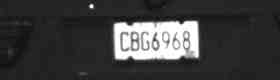

--------------------------------------------------
VRN:  GT674I
Rekognition VRN:  ARGT67AOGrGT674I0


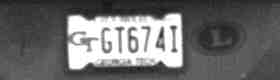

--------------------------------------------------
VRN:  PMC1865
Rekognition VRN:  A


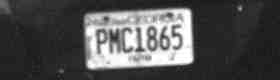

--------------------------------------------------
VRN:  CBX1617
Rekognition VRN:  omd


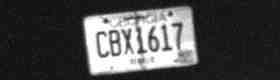

--------------------------------------------------
VRN:  0SJ1001
Rekognition VRN:  2


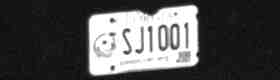

--------------------------------------------------
VRN:  PLG4941
Rekognition VRN:  AGT5732


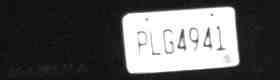

--------------------------------------------------
VRN:  PNT2817
Rekognition VRN:  PNT2817PNT2817


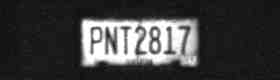

--------------------------------------------------
VRN:  WX2ELK
Rekognition VRN:  V2EUNWXZELK


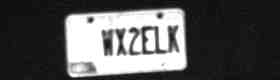

--------------------------------------------------
VRN:  BBN0433
Rekognition VRN:  8018AMT


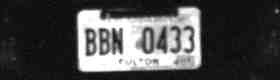

--------------------------------------------------
VRN:  CAW4332
Rekognition VRN:  CAM3321CAW4332


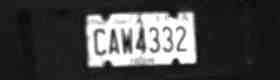

--------------------------------------------------
VRN:  CDL0226
Rekognition VRN:  COLO226CDLO226


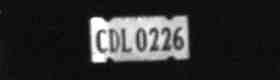

--------------------------------------------------
VRN:  LM6415
Rekognition VRN:  LM6413LM6415LM6415


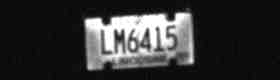

--------------------------------------------------
VRN:  E1N1IY
Rekognition VRN:  800XFIMTY


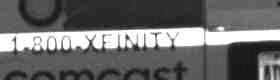

--------------------------------------------------
VRN:  C0TY1C
Rekognition VRN:  comcasto


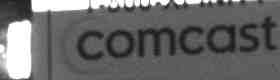

--------------------------------------------------
VRN:  PL160
Rekognition VRN:  PRL16DPRL


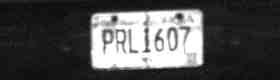

--------------------------------------------------
VRN:  SPTCLY
Rekognition VRN:  SPICLYSPTCLY


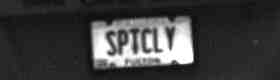

--------------------------------------------------
VRN:  DKC710
Rekognition VRN:  AR1IA


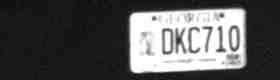

--------------------------------------------------
VRN:  PIQ8013
Rekognition VRN:  Pi08O13P10801326VL


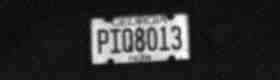

--------------------------------------------------
VRN:  PPK8034
Rekognition VRN:  di


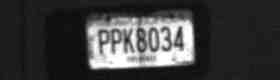

--------------------------------------------------
VRN:  POA7134
Rekognition VRN:  POA7I34P0A7134


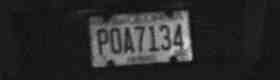

--------------------------------------------------
VRN:  NXED8M
Rekognition VRN:  TUD9TUXEDOY


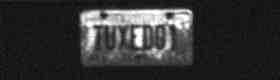

--------------------------------------------------
VRN:  TZ595C
Rekognition VRN:  PMy889


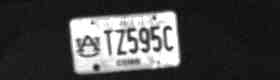

--------------------------------------------------
VRN:  GT674I
Rekognition VRN:  GI674T6T6747


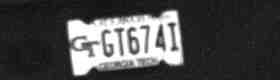

--------------------------------------------------
VRN:  PKQ7539
Rekognition VRN:  00714P07530


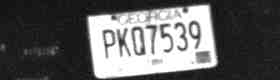

--------------------------------------------------
VRN:  TR5425
Rekognition VRN:  0554255425229


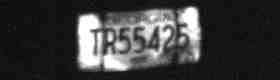

--------------------------------------------------
VRN:  CBS5274
Rekognition VRN:  CBSS274.48552741.


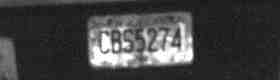

--------------------------------------------------
VRN:  PJC4273
Rekognition VRN:  TPJCI27PJC4273


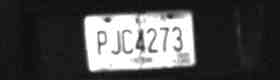

--------------------------------------------------
VRN:  BV8649
Rekognition VRN:  EV8S4-818645


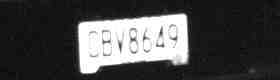

--------------------------------------------------
VRN:  BQ1AEN
Rekognition VRN:  WY4BRS


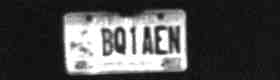

--------------------------------------------------
VRN:  PHF3872
Rekognition VRN:  .'PHF3872PHF3872E


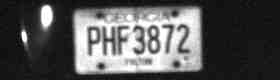

--------------------------------------------------
VRN:  CDL0226
Rekognition VRN:  CDLO226CDLO226


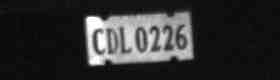

--------------------------------------------------
VRN:  PYE9833
Rekognition VRN:  FYE9833PYE9833


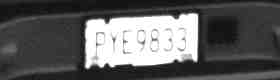

--------------------------------------------------
VRN:  CBU4
Rekognition VRN:  C8U4783


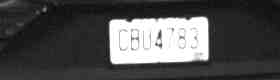

--------------------------------------------------
VRN:  TIMKLI
Rekognition VRN:  SRNNGE


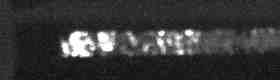

--------------------------------------------------
VRN:  0RT8032
Rekognition VRN:  ORTBO3ZORT802


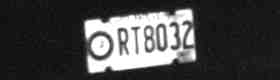

--------------------------------------------------
VRN:  TLW452
Rekognition VRN:  A


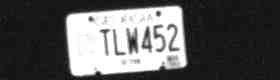

--------------------------------------------------
VRN:  PPE4617
Rekognition VRN:  PPEA617PPE4617


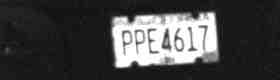

--------------------------------------------------
VRN:  GV12849
Rekognition VRN:  GV12849GV12849


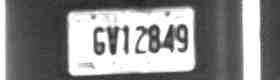

--------------------------------------------------
VRN:  PMC454
Rekognition VRN:  PNC454GPMC4549


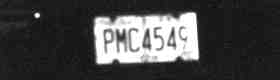

--------------------------------------------------
VRN:  DC90I0
Rekognition VRN:  IDC9OTODC90IOPOL


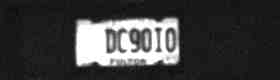

--------------------------------------------------
VRN:  PDD4262
Rekognition VRN:  P00426213.1


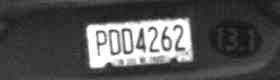

--------------------------------------------------
VRN:  PHN8612
Rekognition VRN:  LLA8520


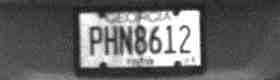

--------------------------------------------------
VRN:  CCA3398
Rekognition VRN:  ACD2910


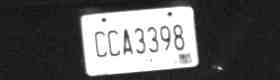

--------------------------------------------------
VRN:  CCN5086
Rekognition VRN:  LLNSOR


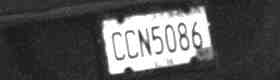

--------------------------------------------------
VRN:  AAA7863
Rekognition VRN:  CBT1634


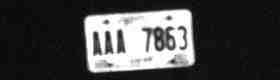

--------------------------------------------------
VRN:  PFG7543
Rekognition VRN:  PFG754PFG7543


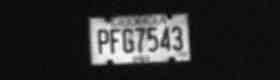

--------------------------------------------------
VRN:  PLB4965
Rekognition VRN:  ATS0769


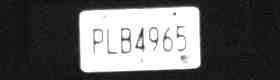

--------------------------------------------------
VRN:  1DEA215
Rekognition VRN:  eDEA215DEA215


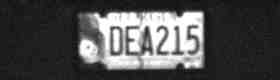

--------------------------------------------------
VRN:  PJG1201
Rekognition VRN:  Go;


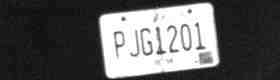

--------------------------------------------------
VRN:  11CN154
Rekognition VRN:  I11CN154CN154


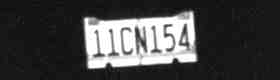

--------------------------------------------------
VRN:  PDA5707
Rekognition VRN:  0


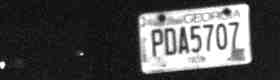

--------------------------------------------------
VRN:  WX2ELK
Rekognition VRN:  2EUNWx2ELK


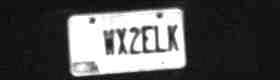

--------------------------------------------------
VRN:  329ZPS
Rekognition VRN:  J29.7pc


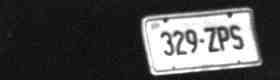

--------------------------------------------------
VRN:  SPTCLY
Rekognition VRN:  SPYSPICLY1


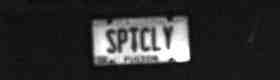

--------------------------------------------------
VRN:  BW8053
Rekognition VRN:  CV80SBW8053


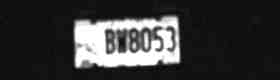

--------------------------------------------------
VRN:  111UD5
Rekognition VRN:  HU5155


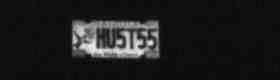

--------------------------------------------------
VRN:  BIU676
Rekognition VRN:  0419675


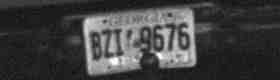

--------------------------------------------------
VRN:  T4347
Rekognition VRN:  CCI14347


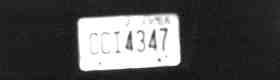

--------------------------------------------------
VRN:  CCA8
Rekognition VRN:  CCA8520


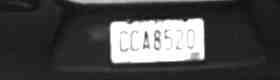

--------------------------------------------------
VRN:  PMC6
Rekognition VRN:  PMC6504


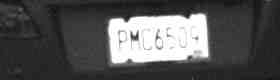

--------------------------------------------------
VRN:  PR22
Rekognition VRN:  PRV2222


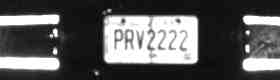

--------------------------------------------------
VRN:  PJY8248
Rekognition VRN:  P18093


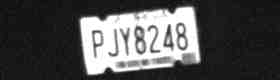

--------------------------------------------------
VRN:  PVZ8935
Rekognition VRN:  PJF8420


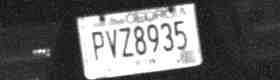

--------------------------------------------------
VRN:  CCY5727
Rekognition VRN:  CCP2TCCY5727


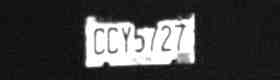

--------------------------------------------------
VRN:  GV6038D
Rekognition VRN:  66O3AL


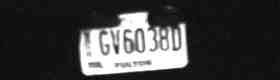

--------------------------------------------------
VRN:  0XF394F
Rekognition VRN:  0XF394XF394F


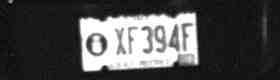

--------------------------------------------------
VRN:  7128ADY
Rekognition VRN:  7128-08.8ADY


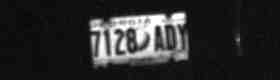

--------------------------------------------------
VRN:  CCJ2484
Rekognition VRN:  CPXBACCJ2484


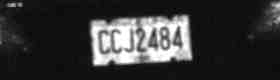

--------------------------------------------------
VRN:  PNT7481
Rekognition VRN:  PTTA8PNT7481


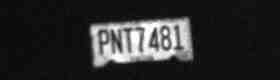

--------------------------------------------------
VRN:  GL86J3
Rekognition VRN:  GL86J32110


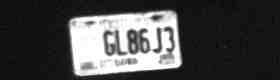

--------------------------------------------------
VRN:  J58642
Rekognition VRN:  158


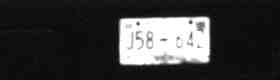

--------------------------------------------------
VRN:  BZIM76
Rekognition VRN:  B419676


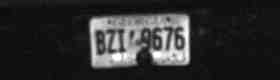

--------------------------------------------------
VRN:  1BD7MD
Rekognition VRN:  1B7240


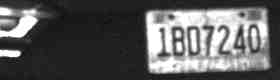

--------------------------------------------------
VRN:  DM391
Rekognition VRN:  DRL393


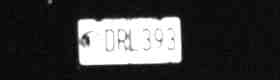

--------------------------------------------------
VRN:  CCB34
Rekognition VRN:  EC8340


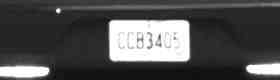

--------------------------------------------------
VRN:  CBJ89
Rekognition VRN:  C8J8982


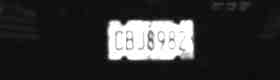

--------------------------------------------------
VRN:  W2ELK
Rekognition VRN:  WYZELX


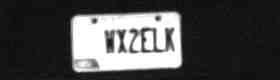

--------------------------------------------------
VRN:  PTV9C
Rekognition VRN:  PTV9053


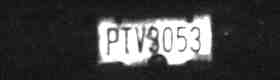

--------------------------------------------------
VRN:  PQ180
Rekognition VRN:  PCCZ180


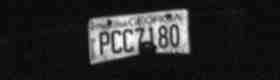

--------------------------------------------------
VRN:  C792G
Rekognition VRN:  CCV7920


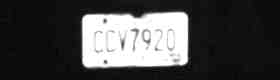

--------------------------------------------------
VRN:  H4359
Rekognition VRN:  812359


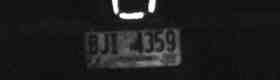

--------------------------------------------------
VRN:  BZI9676
Rekognition VRN:  84149676


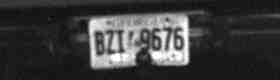

--------------------------------------------------
VRN:  0FS743B
Rekognition VRN:  OFS7R


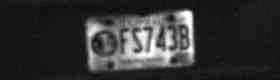

--------------------------------------------------
VRN:  POD4262
Rekognition VRN:  P0042623.


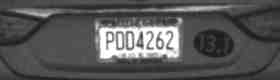

--------------------------------------------------
VRN:  PMC6509
Rekognition VRN:  F6500


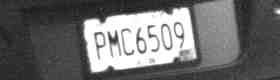

--------------------------------------------------
VRN:  CCE2893
Rekognition VRN:  LE2802


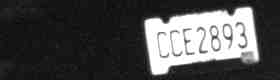

--------------------------------------------------
VRN:  CDI4709
Rekognition VRN:  L014700


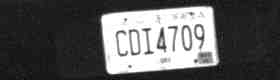

--------------------------------------------------
VRN:  BZI9676
Rekognition VRN:  84109676


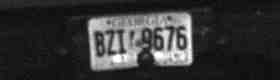

--------------------------------------------------
VRN:  DUQ414
Rekognition VRN:  DUO4


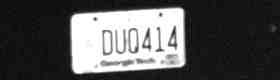

--------------------------------------------------
VRN:  T0PD0C
Rekognition VRN:  TOPDor


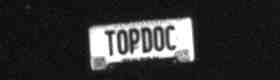

--------------------------------------------------
VRN:  TZ595C
Rekognition VRN:  A12595C


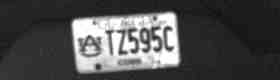

--------------------------------------------------
VRN:  SJ1001
Rekognition VRN:  JJ10or


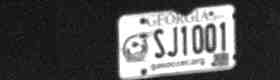

--------------------------------------------------
VRN:  PQH564
Rekognition VRN:  POW7564


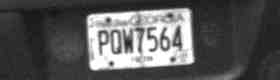

--------------------------------------------------
VRN:  MD3758
Rekognition VRN:  BGE3758


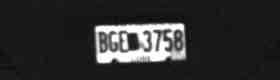

--------------------------------------------------
VRN:  GL52J5
Rekognition VRN:  6L52./5


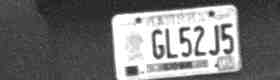

--------------------------------------------------
VRN:  BQ9IKU
Rekognition VRN:  B9I


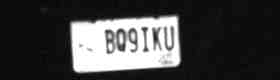

--------------------------------------------------
VRN:  PTH053
Rekognition VRN:  PIV8053


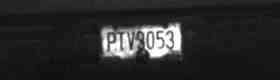

--------------------------------------------------
VRN:  U1253H
Rekognition VRN:  uU253


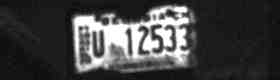

--------------------------------------------------
VRN:  TZ373G
Rekognition VRN:  A373


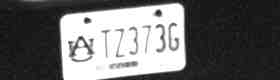

--------------------------------------------------
VRN:  BZIM76
Rekognition VRN:  BZ19676


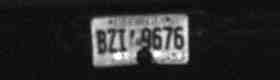

--------------------------------------------------
VRN:  VDYZ860
Rekognition VRN:  UY860


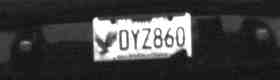

--------------------------------------------------
VRN:  Y0BP0H0
Rekognition VRN:  YOBPOHO


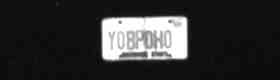

--------------------------------------------------
VRN:  BQQ1520
Rekognition VRN:  Boo520


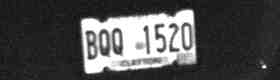

--------------------------------------------------
VRN:  1BD5781
Rekognition VRN:  P805781


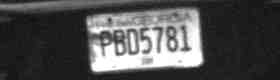

--------------------------------------------------
VRN:  CBW1694
Rekognition VRN:  LBWI69A


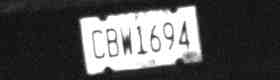

--------------------------------------------------
VRN:  PAG6011
Rekognition VRN:  PAG6OLI


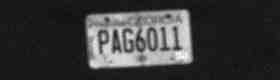

--------------------------------------------------
VRN:  PKF6679
Rekognition VRN:  WE6679


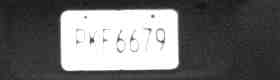

--------------------------------------------------
VRN:  PKI8093
Rekognition VRN:  P18092


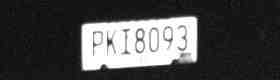

--------------------------------------------------
VRN:  PFC0358
Rekognition VRN:  FFCO35


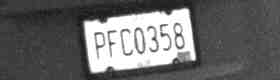

--------------------------------------------------
VRN:  CBW1694
Rekognition VRN:  LBW16O


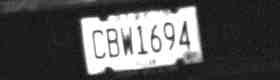

--------------------------------------------------
VRN:  PJF4047
Rekognition VRN:  E4047


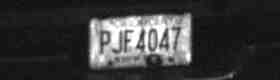

--------------------------------------------------
VRN:  CCB5703
Rekognition VRN:  LB5702


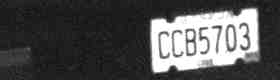

--------------------------------------------------
VRN:  CCT9563
Rekognition VRN:  LT9562


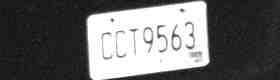

--------------------------------------------------
VRN:  11CN154
Rekognition VRN:  IICNI54


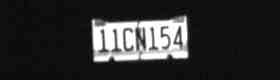

--------------------------------------------------
VRN:  10RL393
Rekognition VRN:  6DDRL393


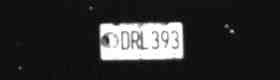

--------------------------------------------------
VRN:  IBQ5BZ1
Rekognition VRN:  BQ5B7


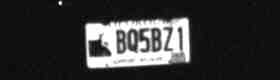

--------------------------------------------------
VRN:  CCA5431
Rekognition VRN:  CI4543/


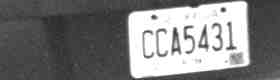

--------------------------------------------------
VRN:  CBG9759
Rekognition VRN:  8G9750


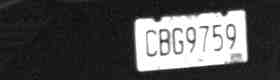

--------------------------------------------------
VRN:  PZG8852
Rekognition VRN:  F468852


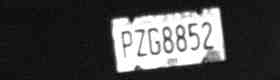

--------------------------------------------------
VRN:  0083AL2
Rekognition VRN:  083412


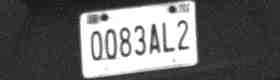

--------------------------------------------------
VRN:  CDL9853
Rekognition VRN:  U9853


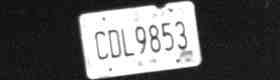

--------------------------------------------------
VRN:  PFH4509
Rekognition VRN:  HH4500


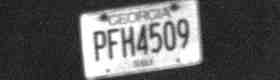

--------------------------------------------------
VRN:  PHI1789
Rekognition VRN:  Ph11780


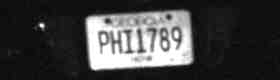

--------------------------------------------------
VRN:  NCTHEEL
Rekognition VRN:  NOTHEF


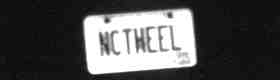

--------------------------------------------------
VRN:  PJN2481
Rekognition VRN:  N248


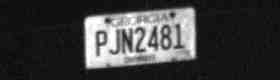

--------------------------------------------------
VRN:  PKQ7539
Rekognition VRN:  wPK07530


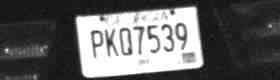

--------------------------------------------------
VRN:  A3118
Rekognition VRN:  22A3118


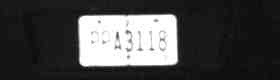

--------------------------------------------------
VRN:  PKH22
Rekognition VRN:  PKH2275


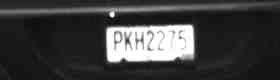

--------------------------------------------------
VRN:  WX34M
Rekognition VRN:  WX34NK


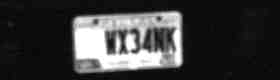

--------------------------------------------------
VRN:  P4336
Rekognition VRN:  COP4336


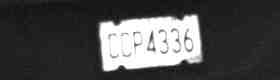

--------------------------------------------------
VRN:  A7451
Rekognition VRN:  ADP7451


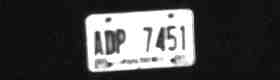

--------------------------------------------------
VRN:  T6474
Rekognition VRN:  PLT6474


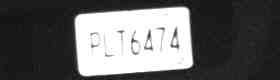

--------------------------------------------------
VRN:  HW447
Rekognition VRN:  HN47


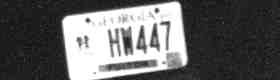

--------------------------------------------------
VRN:  CC574
Rekognition VRN:  CCY5747


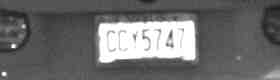

--------------------------------------------------
VRN:  W7AIU
Rekognition VRN:  WX7ATU


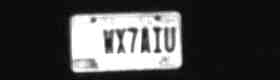

--------------------------------------------------
VRN:  HW936
Rekognition VRN:  1H936


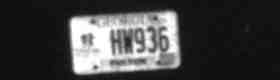

--------------------------------------------------
VRN:  B5BZ1
Rekognition VRN:  BQ5BZ


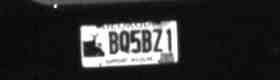

--------------------------------------------------
VRN:  CBE77
Rekognition VRN:  CBET


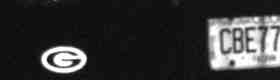

--------------------------------------------------
VRN:  J5388
Rekognition VRN:  COJ5388


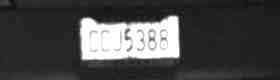

--------------------------------------------------
VRN:  HW795
Rekognition VRN:  H7o5


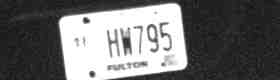

--------------------------------------------------
VRN:  B3605
Rekognition VRN:  BGC3605


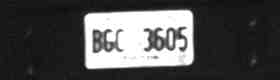

--------------------------------------------------
VRN:  1GT31
Rekognition VRN:  GrGT31


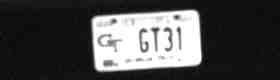

--------------------------------------------------
VRN:  PYV99
Rekognition VRN:  PYV9926


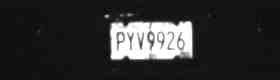

--------------------------------------------------
VRN:  DXJ8V
Rekognition VRN:  DXJ


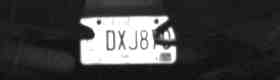

--------------------------------------------------
VRN:  PS175
Rekognition VRN:  PSU1752


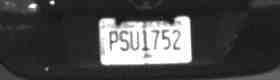

--------------------------------------------------
VRN:  KR794R
Rekognition VRN:  PKR794B


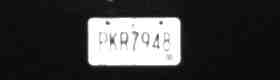

--------------------------------------------------
VRN:  CY7926
Rekognition VRN:  CCV7926


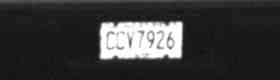

--------------------------------------------------
VRN:  B05235
Rekognition VRN:  C805235


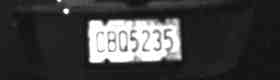

--------------------------------------------------
VRN:  1HF09G
Rekognition VRN:  HFO9G


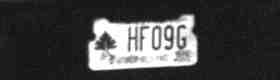

--------------------------------------------------
VRN:  GL9F17
Rekognition VRN:  Gl9f17


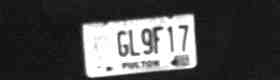

--------------------------------------------------
VRN:  PMY889
Rekognition VRN:  PAY88O


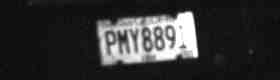

--------------------------------------------------
VRN:  AF2382
Rekognition VRN:  PRF2382


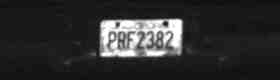

--------------------------------------------------
VRN:  DRL39J
Rekognition VRN:  DRL343


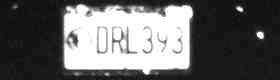

--------------------------------------------------
VRN:  DQV384
Rekognition VRN:  IDOV384


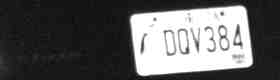

--------------------------------------------------
VRN:  WI4022
Rekognition VRN:  4022


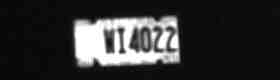

--------------------------------------------------
VRN:  MT1254
Rekognition VRN:  IMT254


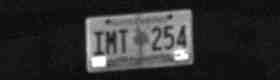

--------------------------------------------------
VRN:  C8H463
Rekognition VRN:  CBH4632


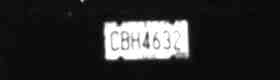

--------------------------------------------------
VRN:  CNAEAT
Rekognition VRN:  CNWHEAT


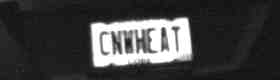

--------------------------------------------------
VRN:  WL8E47
Rekognition VRN:  8EWL8E47


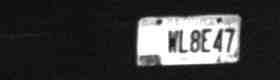

--------------------------------------------------
VRN:  PPH692
Rekognition VRN:  PPF3692


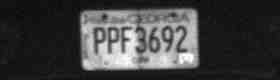

--------------------------------------------------
VRN:  TZ595C
Rekognition VRN:  AyTZ595C


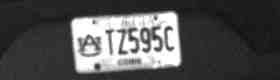

--------------------------------------------------
VRN:  902NCA
Rekognition VRN:  902MCAA


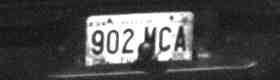

--------------------------------------------------
VRN:  PD2242
Rekognition VRN:  JC2242


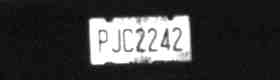

--------------------------------------------------
VRN:  DJS291
Rekognition VRN:  UJS201


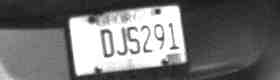

--------------------------------------------------
VRN:  GT471M
Rekognition VRN:  GT47IN


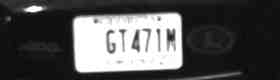

--------------------------------------------------
VRN:  PAD137
Rekognition VRN:  PAN9137


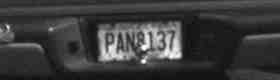

--------------------------------------------------
VRN:  B05235
Rekognition VRN:  -805235


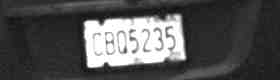

--------------------------------------------------
VRN:  HU24AM
Rekognition VRN:  HUZ4AN


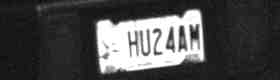

--------------------------------------------------
VRN:  WD412X
Rekognition VRN:  WD41ZY


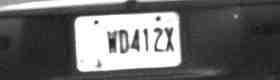

--------------------------------------------------
VRN:  DSQ924
Rekognition VRN:  0S0924


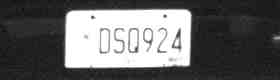

--------------------------------------------------
VRN:  GT674I
Rekognition VRN:  GGT6741


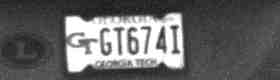

--------------------------------------------------
VRN:  WD51IW
Rekognition VRN:  WD51


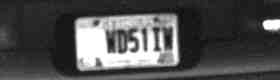

--------------------------------------------------
VRN:  PSW19M
Rekognition VRN:  PSW196A


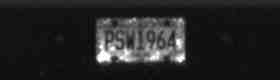

--------------------------------------------------
VRN:  CS5274
Rekognition VRN:  C8S5274.


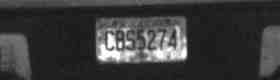

--------------------------------------------------
VRN:  T0PD0C
Rekognition VRN:  TOPDOC


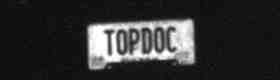

--------------------------------------------------
VRN:  HE8984
Rekognition VRN:  PSE8984


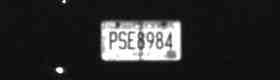

--------------------------------------------------
VRN:  PNM669
Rekognition VRN:  PNA3669


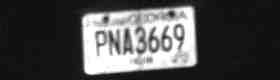

--------------------------------------------------
VRN:  PCCA80
Rekognition VRN:  PCCZ180


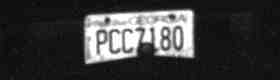

--------------------------------------------------
VRN:  TU851C
Rekognition VRN:  1U851


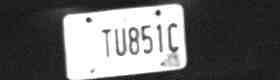

--------------------------------------------------
VRN:  BE9618
Rekognition VRN:  C8E9618


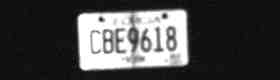

--------------------------------------------------
VRN:  JA970L
Rekognition VRN:  JA97ol


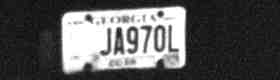

--------------------------------------------------
VRN:  888XWV
Rekognition VRN:  888Xny


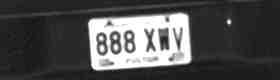

--------------------------------------------------
VRN:  CN1864
Rekognition VRN:  Ln1864


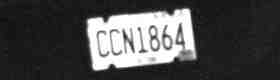

--------------------------------------------------
VRN:  1XJ87C
Rekognition VRN:  3XJ870


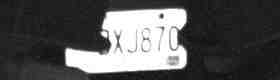

--------------------------------------------------
VRN:  GUMD0C
Rekognition VRN:  GUNDOC


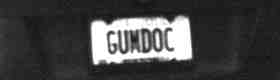

--------------------------------------------------
VRN:  1JN84X
Rekognition VRN:  JN84Y


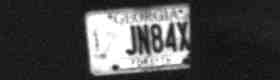

--------------------------------------------------
VRN:  BQ90DQ
Rekognition VRN:  BQ9ODO


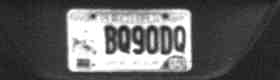

--------------------------------------------------
VRN:  DRC701
Rekognition VRN:  DRC7O


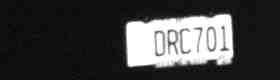

--------------------------------------------------
VRN:  0083AL2
Rekognition VRN:  0083412


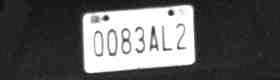

--------------------------------------------------
VRN:  CDB5516
Rekognition VRN:  D85516


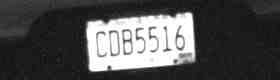

--------------------------------------------------
VRN:  AAW5233
Rekognition VRN:  Al5233


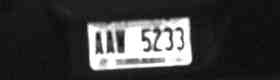

--------------------------------------------------
VRN:  PIZ6836
Rekognition VRN:  P12Z6836


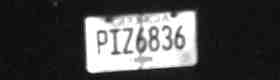

--------------------------------------------------
VRN:  CCA8520
Rekognition VRN:  LA8520


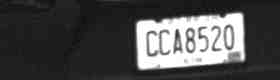

--------------------------------------------------
VRN:  0SJ1001
Rekognition VRN:  OSJ10O1


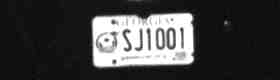

--------------------------------------------------
VRN:  AMX9588
Rekognition VRN:  AHY9588


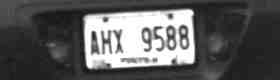

--------------------------------------------------
VRN:  CCA4050
Rekognition VRN:  LEA4050


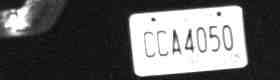

--------------------------------------------------
VRN:  PFC0358
Rekognition VRN:  PFCO359


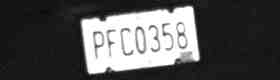

--------------------------------------------------
VRN:  CDK9904
Rekognition VRN:  LOK9904


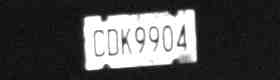

--------------------------------------------------
VRN:  ZF12399
Rekognition VRN:  ZH-2399


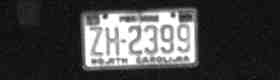

--------------------------------------------------
VRN:  CBB9516
Rekognition VRN:  CBB95


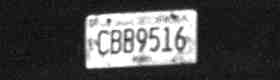

--------------------------------------------------
VRN:  BNQ1367
Rekognition VRN:  BNO367


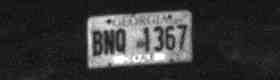

--------------------------------------------------
VRN:  BQF1803
Rekognition VRN:  BOF803


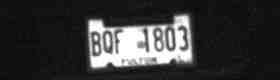

--------------------------------------------------
VRN:  GV14480
Rekognition VRN:  14480


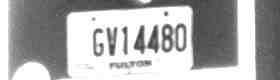

--------------------------------------------------
VRN:  AWF1300
Rekognition VRN:  ANF300


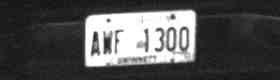

--------------------------------------------------
VRN:  PWN3339
Rekognition VRN:  PWN3.330


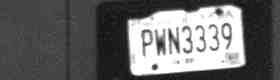

--------------------------------------------------
VRN:  PDB1938
Rekognition VRN:  IB1938


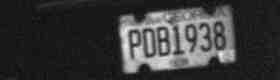

--------------------------------------------------
VRN:  CDS2381
Rekognition VRN:  LIS2381


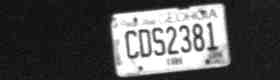

--------------------------------------------------
VRN:  CBV8208
Rekognition VRN:  C8V820G


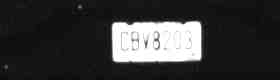

--------------------------------------------------
VRN:  PYB5384
Rekognition VRN:  PYB5.38


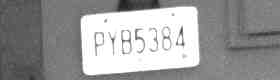

--------------------------------------------------
VRN:  CCF3122
Rekognition VRN:  LLF3122


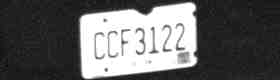

--------------------------------------------------
VRN:  PNTI503
Rekognition VRN:  PN7503


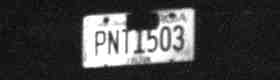

--------------------------------------------------
VRN:  PBD9165
Rekognition VRN:  P809165


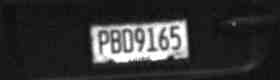

--------------------------------------------------
VRN:  BQF2216
Rekognition VRN:  BOF216


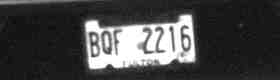

--------------------------------------------------
VRN:  BQQ1520
Rekognition VRN:  BOQ-1520


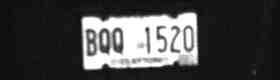

--------------------------------------------------
VRN:  CCA8520
Rekognition VRN:  LA8520


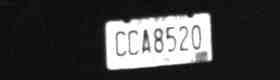

--------------------------------------------------
VRN:  COF5475
Rekognition VRN:  LDF5475


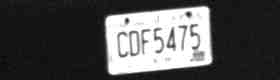

--------------------------------------------------
VRN:  AHW7834
Rekognition VRN:  AH783


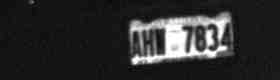

--------------------------------------------------
VRN:  BQF1989
Rekognition VRN:  BoFl989


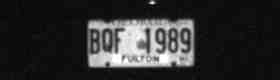

--------------------------------------------------
VRN:  0SJ1001
Rekognition VRN:  OSJ100


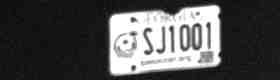

--------------------------------------------------
VRN:  CBW1694
Rekognition VRN:  LBW169


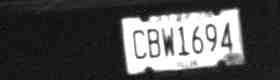

--------------------------------------------------
VRN:  CCE6569
Rekognition VRN:  LCE6560


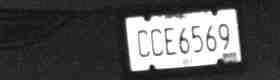

--------------------------------------------------
VRN:  153190K
Rekognition VRN:  R5390K


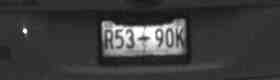

--------------------------------------------------
VRN:  PXW2772
Rekognition VRN:  PN2772


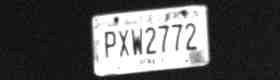

--------------------------------------------------
VRN:  PFC0358
Rekognition VRN:  PFCO35R


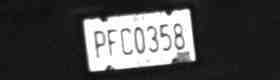

--------------------------------------------------
VRN:  PKN1999
Rekognition VRN:  PKN1900


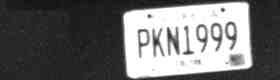

--------------------------------------------------
VRN:  BQN9136
Rekognition VRN:  BON0136


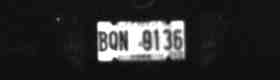

--------------------------------------------------
VRN:  PKQ7539
Rekognition VRN:  PK07530


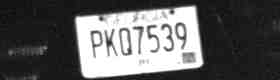

--------------------------------------------------
VRN:  CDU9764
Rekognition VRN:  LOU9764


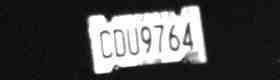

--------------------------------------------------
VRN:  BLS1924
Rekognition VRN:  BLS9245


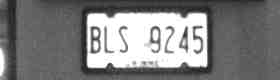

--------------------------------------------------
VRN:  AAA7863
Rekognition VRN:  AM7863


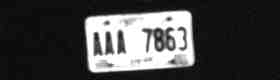

--------------------------------------------------
VRN:  PVA9609
Rekognition VRN:  PV49600


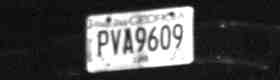

--------------------------------------------------
VRN:  JWDT0RG
Rekognition VRN:  JWDIORG


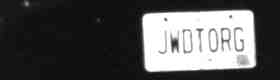

--------------------------------------------------
VRN:  CDE4576
Rekognition VRN:  LUE4576


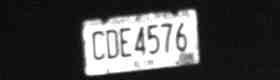

--------------------------------------------------
VRN:  PIZ4455
Rekognition VRN:  P24455


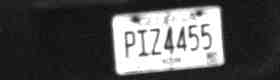

--------------------------------------------------
VRN:  CBQ1847
Rekognition VRN:  C801847


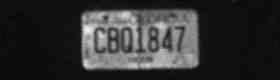

--------------------------------------------------
VRN:  PGB5090
Rekognition VRN:  P685090


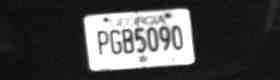

--------------------------------------------------
VRN:  1BD7240
Rekognition VRN:  1807240


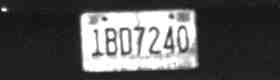

--------------------------------------------------
VRN:  CCE6569
Rekognition VRN:  LCE6560


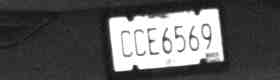

--------------------------------------------------
VRN:  CBZ6320
Rekognition VRN:  L8Z6320


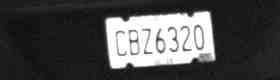

--------------------------------------------------
VRN:  1TZ595C
Rekognition VRN:  A1Z595C


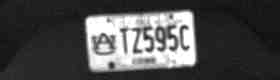

--------------------------------------------------
VRN:  GV5665E
Rekognition VRN:  6V5665F


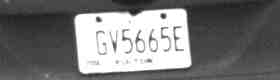

--------------------------------------------------
VRN:  CDJ9135
Rekognition VRN:  C09135


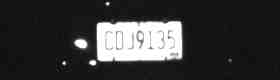

--------------------------------------------------
VRN:  BT6405D
Rekognition VRN:  ABT6405


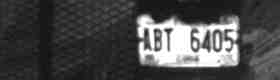

--------------------------------------------------
VRN:  CBV8203
Rekognition VRN:  LBV8202


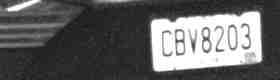

--------------------------------------------------
VRN:  CCI3289
Rekognition VRN:  CI3280


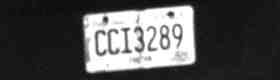

--------------------------------------------------
VRN:  CDF1933
Rekognition VRN:  COF933


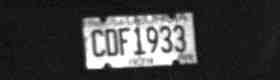

--------------------------------------------------
VRN:  PTU7293
Rekognition VRN:  PTU7202


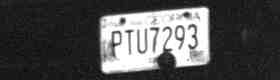

--------------------------------------------------
VRN:  CAU4432
Rekognition VRN:  Cau4432


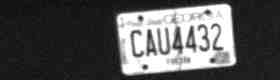

--------------------------------------------------
VRN:  1AF6651
Rekognition VRN:  4F6651


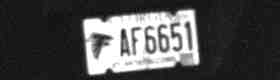

--------------------------------------------------
VRN:  1WF412I
Rekognition VRN:  WF4121


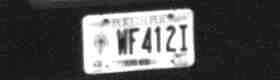

--------------------------------------------------
VRN:  PWN1732
Rekognition VRN:  PAN1Z32


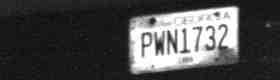

--------------------------------------------------
VRN:  P1V9926
Rekognition VRN:  PY19926


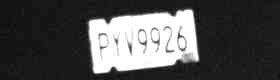

--------------------------------------------------
VRN:  CCP7212
Rekognition VRN:  LP7212


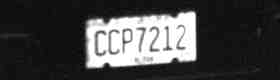

--------------------------------------------------
VRN:  PMC4849
Rekognition VRN:  PNC4840


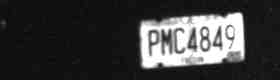

--------------------------------------------------
VRN:  BQF9735
Rekognition VRN:  Bof9735


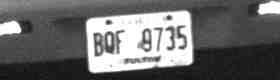

--------------------------------------------------
VRN:  WF19090
Rekognition VRN:  BWF9090


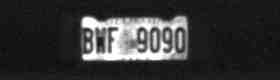

--------------------------------------------------
VRN:  CCA4454
Rekognition VRN:  LlA4454


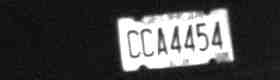

--------------------------------------------------
VRN:  CBV8203
Rekognition VRN:  LBV8202


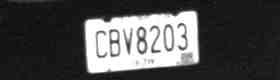

--------------------------------------------------
VRN:  PKS3536
Rekognition VRN:  PK535.36


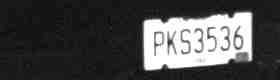

--------------------------------------------------
VRN:  CCE1108
Rekognition VRN:  LE1108


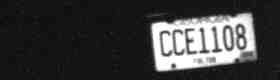

--------------------------------------------------
VRN:  CDS2381
Rekognition VRN:  LIS2381


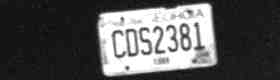

--------------------------------------------------
VRN:  CCA6351
Rekognition VRN:  LA6351


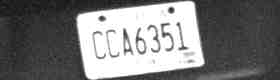

--------------------------------------------------
VRN:  RMB2911
Rekognition VRN:  M02911


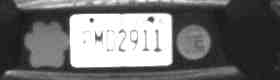

--------------------------------------------------
VRN:  CCP7212
Rekognition VRN:  LLP7212


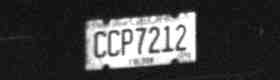

--------------------------------------------------
VRN:  PDD4262
Rekognition VRN:  P004262


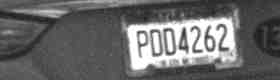

--------------------------------------------------
VRN:  CDG4520
Rekognition VRN:  0G4520


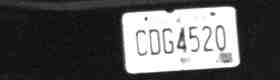

--------------------------------------------------
VRN:  CDI4388
Rekognition VRN:  LII4388


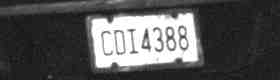

--------------------------------------------------
VRN:  CBB9516
Rekognition VRN:  1B89516


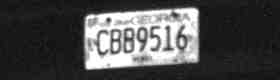

--------------------------------------------------
VRN:  PNTI503
Rekognition VRN:  PN1503


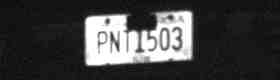

--------------------------------------------------
VRN:  CBD9710
Rekognition VRN:  C809710


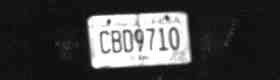

--------------------------------------------------
VRN:  PJN1493
Rekognition VRN:  FJN1492


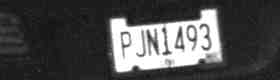

--------------------------------------------------
VRN:  LJA730Y
Rekognition VRN:  JA73OY


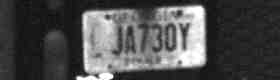

--------------------------------------------------
VRN:  1DKB944
Rekognition VRN:  DKB9444


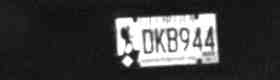

--------------------------------------------------
VRN:  CBJ6440
Rekognition VRN:  LJ6440


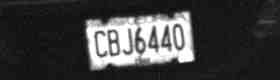

--------------------------------------------------
VRN:  CDD9952
Rekognition VRN:  C009952


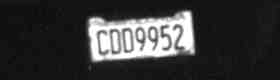

--------------------------------------------------
VRN:  CCA8520
Rekognition VRN:  LLA8520


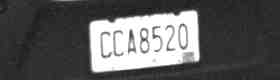

--------------------------------------------------
VRN:  TR8668J
Rekognition VRN:  R8668


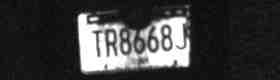

--------------------------------------------------
VRN:  8FS743B
Rekognition VRN:  OFS7438


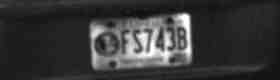

--------------------------------------------------
VRN:  GDLUVSU
Rekognition VRN:  DLVVSU


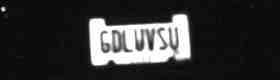

--------------------------------------------------
VRN:  CCB5703
Rekognition VRN:  LLB5703


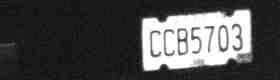

--------------------------------------------------
VRN:  N3WY0RK
Rekognition VRN:  3WYORK


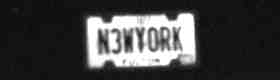

--------------------------------------------------
VRN:  AHX9588
Rekognition VRN:  AY9588


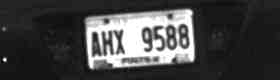

--------------------------------------------------
VRN:  PBD9165
Rekognition VRN:  P809165


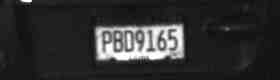

--------------------------------------------------
VRN:  1DTW224
Rekognition VRN:  OTW224


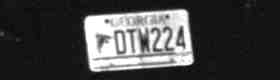

--------------------------------------------------
VRN:  PNTI503
Rekognition VRN:  PN7503


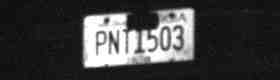

--------------------------------------------------
VRN:  CBZ6320
Rekognition VRN:  B26320


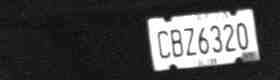

--------------------------------------------------
VRN:  CCF3122
Rekognition VRN:  LLF3122


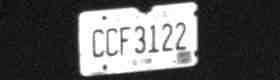

--------------------------------------------------
VRN:  PDD4262
Rekognition VRN:  P004262


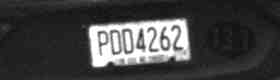

--------------------------------------------------
VRN:  AWZ5222
Rekognition VRN:  AWZ622Z


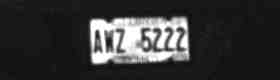

--------------------------------------------------
VRN:  CBI4320
Rekognition VRN:  8I4320


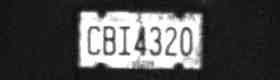

--------------------------------------------------
VRN:  AAM7670
Rekognition VRN:  LAN7670


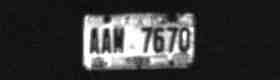

--------------------------------------------------
VRN:  PRZ3174
Rekognition VRN:  PR7317


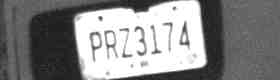

--------------------------------------------------
VRN:  BQF1959
Rekognition VRN:  BOF-1959


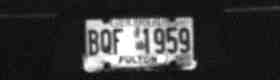

--------------------------------------------------
VRN:  FCBI1026
Rekognition VRN:  C8I1026


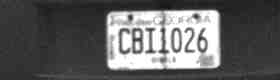

--------------------------------------------------
VRN:  FPDE2616
Rekognition VRN:  POE2616


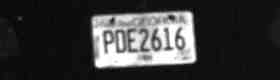

--------------------------------------------------
VRN:  DXJ8M
Rekognition VRN:  DXJ8


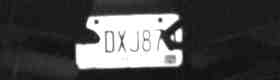

--------------------------------------------------
VRN:  DXJ8N
Rekognition VRN:  DXJ8


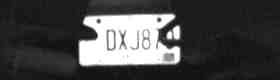

--------------------------------------------------
VRN:  DIAZ0
Rekognition VRN:  DIAZO


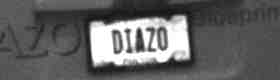

--------------------------------------------------
VRN:  27SE1
Rekognition VRN:  237SE1


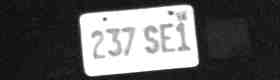

--------------------------------------------------
VRN:  B999C
Rekognition VRN:  BW999C


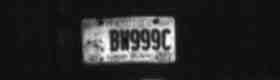

--------------------------------------------------
VRN:  G4941
Rekognition VRN:  LG4941


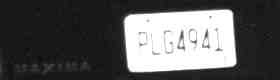

--------------------------------------------------
VRN:  HW447
Rekognition VRN:  H447


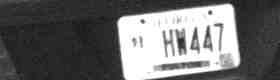

--------------------------------------------------
VRN:  DIAZ0
Rekognition VRN:  DIAZO


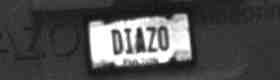

--------------------------------------------------
VRN:  1GA51
Rekognition VRN:  0GA51


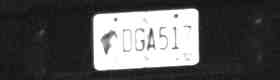

--------------------------------------------------
VRN:  CCC48
Rekognition VRN:  CCC480


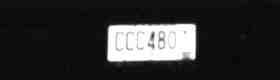

--------------------------------------------------
VRN:  DVT591
Rekognition VRN:  OVT591


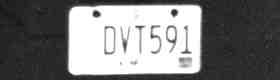

--------------------------------------------------
VRN:  HU24AM
Rekognition VRN:  HU24IM


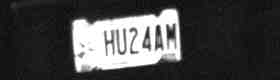

--------------------------------------------------
VRN:  PT7574
Rekognition VRN:  P0T7574


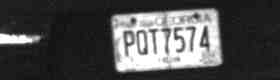

--------------------------------------------------
VRN:  PMZ895
Rekognition VRN:  PMZ8952


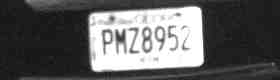

--------------------------------------------------
VRN:  WC6381
Rekognition VRN:  WC638


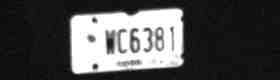

--------------------------------------------------
VRN:  UGA676
Rekognition VRN:  CUGA676


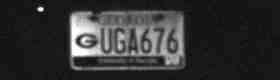

--------------------------------------------------
VRN:  GL9D09
Rekognition VRN:  GL9D0Q


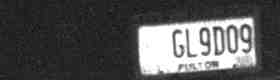

--------------------------------------------------
VRN:  GT674I
Rekognition VRN:  TGT674I


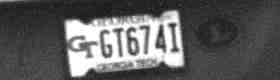

--------------------------------------------------
VRN:  0083AL
Rekognition VRN:  0083AL2


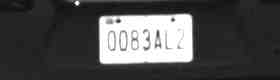

--------------------------------------------------
VRN:  WX4BRS
Rekognition VRN:  WY4BRS


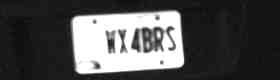

--------------------------------------------------
VRN:  DNJ916
Rekognition VRN:  DN.J916


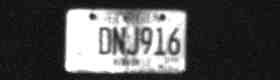

--------------------------------------------------
VRN:  BC3V82
Rekognition VRN:  SBC3V82


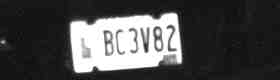

--------------------------------------------------
VRN:  28K8M6
Rekognition VRN:  8K8M6


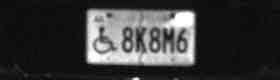

--------------------------------------------------
VRN:  888XWV
Rekognition VRN:  888XNV


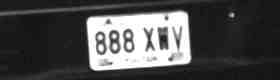

--------------------------------------------------
VRN:  CDG814
Rekognition VRN:  C0G814


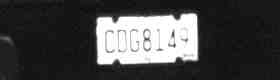

--------------------------------------------------
VRN:  BW221Z
Rekognition VRN:  BWZ21Z


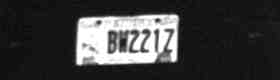

--------------------------------------------------
VRN:  WF97MC
Rekognition VRN:  WF97NC


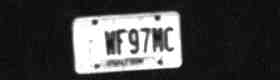

--------------------------------------------------
VRN:  0XJ87M
Rekognition VRN:  0XJ87


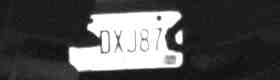

--------------------------------------------------
VRN:  BQ7FJK
Rekognition VRN:  Ba7FJK


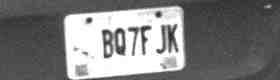

--------------------------------------------------
VRN:  BQ45E5
Rekognition VRN:  B045E5


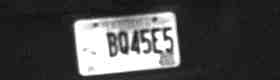

--------------------------------------------------
VRN:  ED6Z64
Rekognition VRN:  DED6Z64


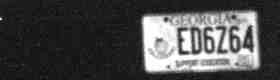

--------------------------------------------------
VRN:  LG4941
Rekognition VRN:  PLG4941


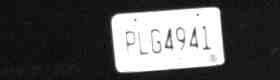

--------------------------------------------------
VRN:  TLW452
Rekognition VRN:  ILW452


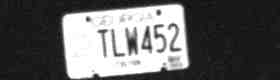

--------------------------------------------------
VRN:  PMC454
Rekognition VRN:  PMC4549


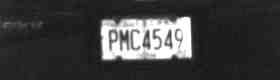

--------------------------------------------------
VRN:  SJ1001
Rekognition VRN:  aSJ1001


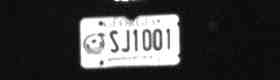

--------------------------------------------------
VRN:  BQ90DQ
Rekognition VRN:  BQ9ODQ


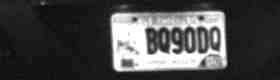

--------------------------------------------------
VRN:  317MUK
Rekognition VRN:  317MK


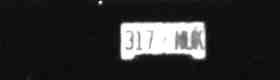

--------------------------------------------------
VRN:  PMY889
Rekognition VRN:  PMy889


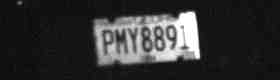

--------------------------------------------------
VRN:  PLB496
Rekognition VRN:  PLB4965


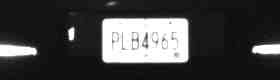

--------------------------------------------------
VRN:  404YYJ
Rekognition VRN:  404YY.


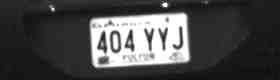

--------------------------------------------------
VRN:  JG1006
Rekognition VRN:  FJG1006


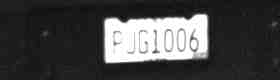

--------------------------------------------------
VRN:  DJX150
Rekognition VRN:  JX150


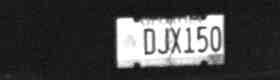

--------------------------------------------------
VRN:  DVM308
Rekognition VRN:  OVM308


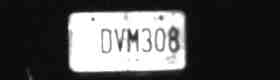

--------------------------------------------------
VRN:  HW1177
Rekognition VRN:  HW117T


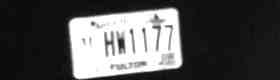

--------------------------------------------------
VRN:  EH1382
Rekognition VRN:  EM1382


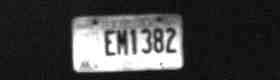

--------------------------------------------------
VRN:  WX2ELK
Rekognition VRN:  WX2EK


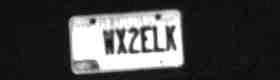

--------------------------------------------------
VRN:  PB2245
Rekognition VRN:  PGB2245


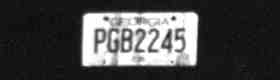

--------------------------------------------------
VRN:  WX66NI
Rekognition VRN:  WX66NT


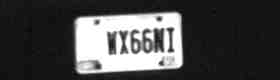

--------------------------------------------------
VRN:  JC2364
Rekognition VRN:  FJC2364


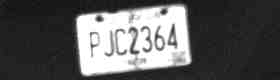

--------------------------------------------------
VRN:  GL9F17
Rekognition VRN:  &GL9F17


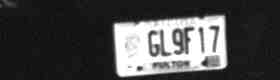

--------------------------------------------------
VRN:  BQ4DT0
Rekognition VRN:  BQ4DTO


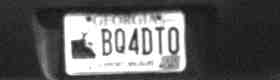

--------------------------------------------------
VRN:  BW1366
Rekognition VRN:  BWI366


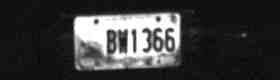

--------------------------------------------------
VRN:  DMC975
Rekognition VRN:  ODMC975


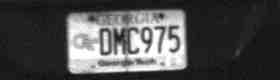

--------------------------------------------------
VRN:  PMY889
Rekognition VRN:  PMY880


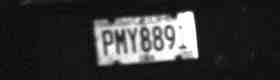

--------------------------------------------------
VRN:  CF220G
Rekognition VRN:  CF22OG


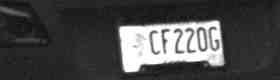

--------------------------------------------------
VRN:  ED9W73
Rekognition VRN:  ED973


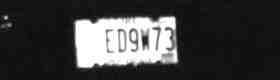

--------------------------------------------------
VRN:  KN1754
Rekognition VRN:  PKN1754


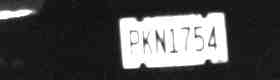

--------------------------------------------------
VRN:  GL9D09
Rekognition VRN:  GL9DO9


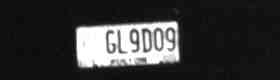

--------------------------------------------------
VRN:  0083AL
Rekognition VRN:  0083AL2


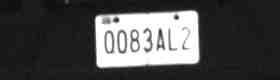

--------------------------------------------------
VRN:  DJL345
Rekognition VRN:  DJ345


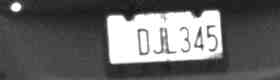

--------------------------------------------------
VRN:  GL60R9
Rekognition VRN:  GL60RQ


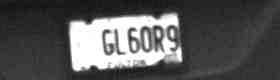

--------------------------------------------------
VRN:  UYZ860
Rekognition VRN:  UY860


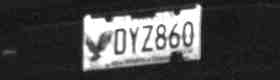

--------------------------------------------------
VRN:  GHS013
Rekognition VRN:  6HS013


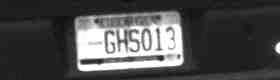

--------------------------------------------------
VRN:  728JFW
Rekognition VRN:  728JFM


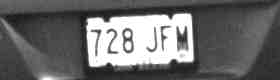

--------------------------------------------------
VRN:  7AF969
Rekognition VRN:  AF969


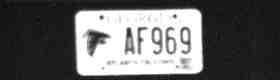

--------------------------------------------------
VRN:  317NUK
Rekognition VRN:  317MUK


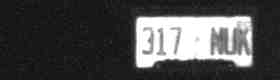

--------------------------------------------------
VRN:  EM1382
Rekognition VRN:  EN1382


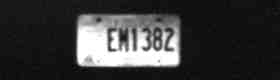

--------------------------------------------------
VRN:  PA4764
Rekognition VRN:  PTA4764


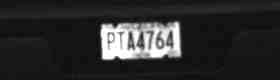

--------------------------------------------------
VRN:  WD21MV
Rekognition VRN:  WD21NV


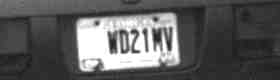

--------------------------------------------------
VRN:  GL60R9
Rekognition VRN:  GL6OR9


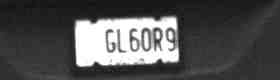

--------------------------------------------------
VRN:  GA25LI
Rekognition VRN:  GA25LT


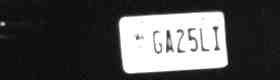

--------------------------------------------------
VRN:  BQ6FEI
Rekognition VRN:  BO6FEI


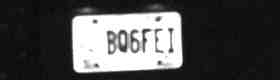

--------------------------------------------------
VRN:  DRC828
Rekognition VRN:  URC828


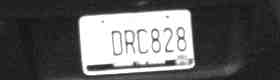

--------------------------------------------------
VRN:  B043E3
Rekognition VRN:  BQ43E3


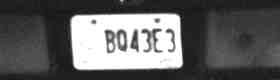

--------------------------------------------------
VRN:  DC5I48
Rekognition VRN:  DC5148


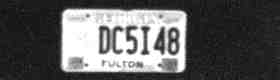

--------------------------------------------------
VRN:  CCC480
Rekognition VRN:  CCC4807


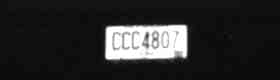

--------------------------------------------------
VRN:  PC8882
Rekognition VRN:  PMC8882


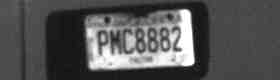

--------------------------------------------------
VRN:  CBX797
Rekognition VRN:  CBX7974


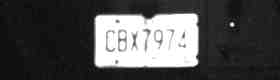

--------------------------------------------------
VRN:  WF9N55
Rekognition VRN:  W9N55


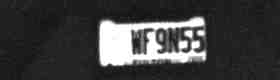

--------------------------------------------------
VRN:  WX4BRS
Rekognition VRN:  MX4BRS


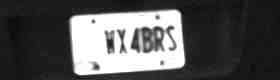

--------------------------------------------------
VRN:  DXQ748
Rekognition VRN:  DX0748


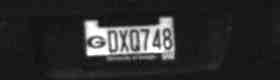

--------------------------------------------------
VRN:  AK2260
Rekognition VRN:  4K2260


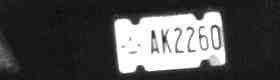

--------------------------------------------------
VRN:  BW999C
Rekognition VRN:  BM999C


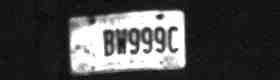

--------------------------------------------------
VRN:  BQ5CTG
Rekognition VRN:  B5CTG


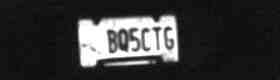

--------------------------------------------------
VRN:  TU826A
Rekognition VRN:  7U826A


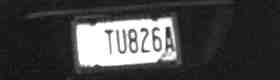

--------------------------------------------------
VRN:  GL9D09
Rekognition VRN:  GL9009


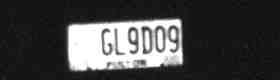

--------------------------------------------------
VRN:  DC4N76
Rekognition VRN:  DO4N76


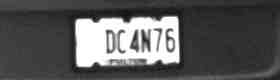

--------------------------------------------------
VRN:  1F03V6
Rekognition VRN:  F03V6


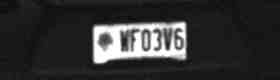

--------------------------------------------------
VRN:  DRC987
Rekognition VRN:  RC987


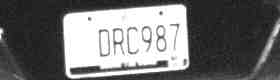

--------------------------------------------------
VRN:  BQ5235
Rekognition VRN:  CBQ5235


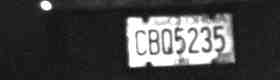

--------------------------------------------------
VRN:  DRL393
Rekognition VRN:  ORL393


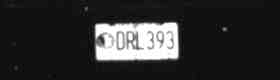

--------------------------------------------------
VRN:  GL9D09
Rekognition VRN:  GL9DO9


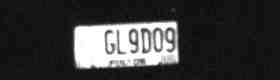

--------------------------------------------------
VRN:  WD16A9
Rekognition VRN:  WD1649


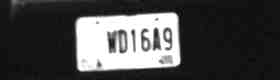

--------------------------------------------------
VRN:  JG1006
Rekognition VRN:  PJG1006


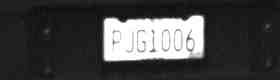

--------------------------------------------------
VRN:  PKK1938
Rekognition VRN:  PKK1928


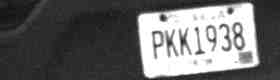

--------------------------------------------------
VRN:  BMQ2251
Rekognition VRN:  BMO2251


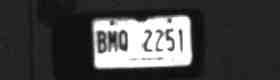

--------------------------------------------------
VRN:  PLS7519
Rekognition VRN:  PLS7510


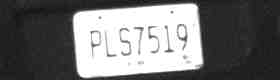

--------------------------------------------------
VRN:  PFA8995
Rekognition VRN:  PF48995


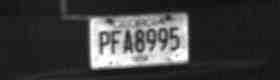

--------------------------------------------------
VRN:  PNS9733
Rekognition VRN:  PNs9733


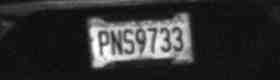

--------------------------------------------------
VRN:  CB05235
Rekognition VRN:  C805235


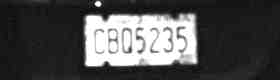

--------------------------------------------------
VRN:  PSU5216
Rekognition VRN:  P5U5216


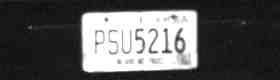

--------------------------------------------------
VRN:  8018AHT
Rekognition VRN:  8018ANT


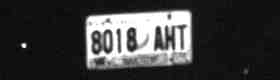

--------------------------------------------------
VRN:  BFQ4813
Rekognition VRN:  BFO4813


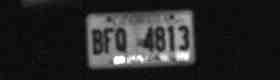

--------------------------------------------------
VRN:  CBW9434
Rekognition VRN:  LBW9434


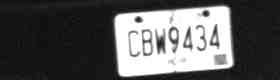

--------------------------------------------------
VRN:  CBU6551
Rekognition VRN:  BU6551


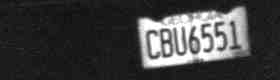

--------------------------------------------------
VRN:  PNW7855
Rekognition VRN:  PNw7855


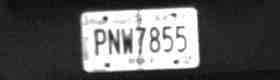

--------------------------------------------------
VRN:  AHT7086
Rekognition VRN:  AMT7086


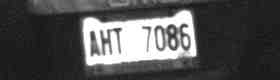

--------------------------------------------------
VRN:  PSU5216
Rekognition VRN:  PEU5216


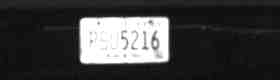

--------------------------------------------------
VRN:  BJX2011
Rekognition VRN:  BJX20111


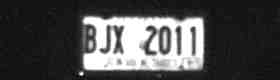

--------------------------------------------------
VRN:  CDR9829
Rekognition VRN:  COR9829


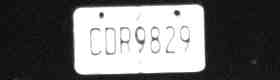

--------------------------------------------------
VRN:  PMD5150
Rekognition VRN:  PM05150


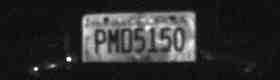

--------------------------------------------------
VRN:  BQA6778
Rekognition VRN:  BOA6778


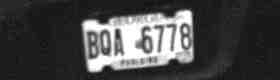

--------------------------------------------------
VRN:  CCB6168
Rekognition VRN:  CC86168


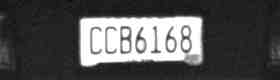

--------------------------------------------------
VRN:  PCS5859
Rekognition VRN:  P4S5859


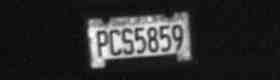

--------------------------------------------------
VRN:  0083AL2
Rekognition VRN:  0083A12


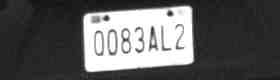

--------------------------------------------------
VRN:  PLF6350
Rekognition VRN:  FLF6350


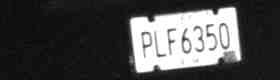

--------------------------------------------------
VRN:  AHX2561
Rekognition VRN:  AMX2561


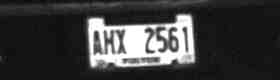

--------------------------------------------------
VRN:  CBU4783
Rekognition VRN:  LBU4783


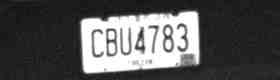

--------------------------------------------------
VRN:  BTF6000
Rekognition VRN:  BTE6000


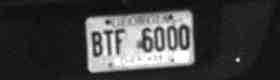

--------------------------------------------------
VRN:  BWG1212
Rekognition VRN:  BWG212


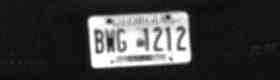

--------------------------------------------------
VRN:  CBW9434
Rekognition VRN:  LBW9434


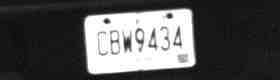

--------------------------------------------------
VRN:  PAB3009
Rekognition VRN:  PAB3000


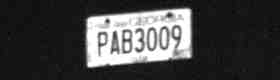

--------------------------------------------------
VRN:  CBU4783
Rekognition VRN:  LBU4783


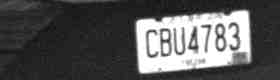

--------------------------------------------------
VRN:  P1C5248
Rekognition VRN:  PKC5248


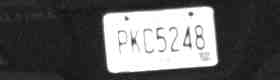

--------------------------------------------------
VRN:  PSE8984
Rekognition VRN:  P5E8984


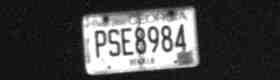

--------------------------------------------------
VRN:  BKS9824
Rekognition VRN:  BKS982


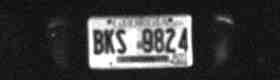

--------------------------------------------------
VRN:  AWR3978
Rekognition VRN:  ANR3978


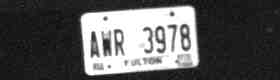

--------------------------------------------------
VRN:  BXE1480
Rekognition VRN:  BXE-1480


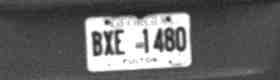

--------------------------------------------------
VRN:  AXL5911
Rekognition VRN:  AXL6911


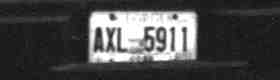

--------------------------------------------------
VRN:  PMC4549
Rekognition VRN:  PHC4549


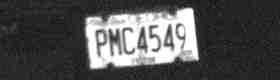

--------------------------------------------------
VRN:  FCS4401
Rekognition VRN:  PCS4401


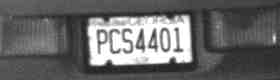

--------------------------------------------------
VRN:  BMW6032
Rekognition VRN:  BMN6032


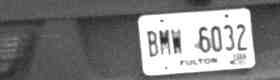

--------------------------------------------------
VRN:  PKS8853
Rekognition VRN:  PK58853


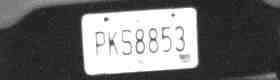

--------------------------------------------------
VRN:  ABG3352
Rekognition VRN:  BG3352


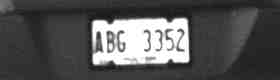

--------------------------------------------------
VRN:  PIQ9458
Rekognition VRN:  PI09458


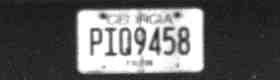

--------------------------------------------------
VRN:  PZJ2557
Rekognition VRN:  P4J2557


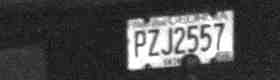

--------------------------------------------------
VRN:  PJM9413
Rekognition VRN:  PM9413


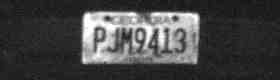

--------------------------------------------------
VRN:  PMC6509
Rekognition VRN:  PMC6500


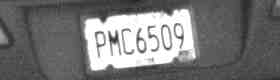

--------------------------------------------------
VRN:  BSM2219
Rekognition VRN:  BS2219


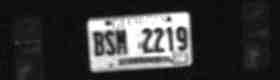

--------------------------------------------------
VRN:  7AF7289
Rekognition VRN:  AF7289


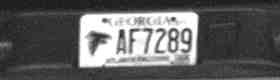

--------------------------------------------------
VRN:  PKI8093
Rekognition VRN:  PK18093


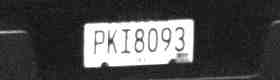

--------------------------------------------------
VRN:  AMZ1930
Rekognition VRN:  AHZ1930


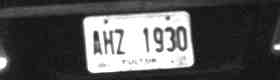

--------------------------------------------------
VRN:  CCB5703
Rekognition VRN:  CC85703


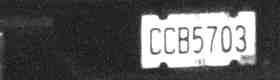

--------------------------------------------------
VRN:  PKQ9247
Rekognition VRN:  PK09247


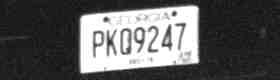

--------------------------------------------------
VRN:  COF5475
Rekognition VRN:  LOF5475


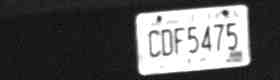

--------------------------------------------------
VRN:  BIR0495
Rekognition VRN:  BXR0495


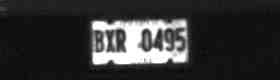

--------------------------------------------------
VRN:  BMZ7991
Rekognition VRN:  BNZ7991


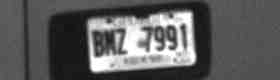

--------------------------------------------------
VRN:  LJA152U
Rekognition VRN:  JA152U


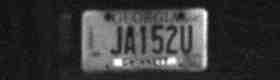

--------------------------------------------------
VRN:  PKI6244
Rekognition VRN:  PK16244


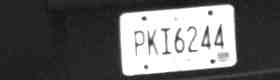

--------------------------------------------------
VRN:  PVY8368
Rekognition VRN:  PY8368


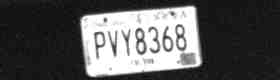

--------------------------------------------------
VRN:  PVA9609
Rekognition VRN:  PVA9600


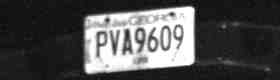

--------------------------------------------------
VRN:  PHI1789
Rekognition VRN:  PH11789


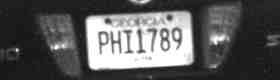

--------------------------------------------------
VRN:  CCB5703
Rekognition VRN:  LCB5703


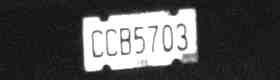

--------------------------------------------------
VRN:  PI09458
Rekognition VRN:  P109458


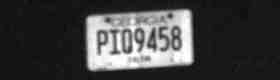

--------------------------------------------------
VRN:  1GT245C
Rekognition VRN:  -GT245C


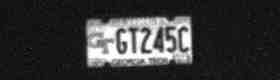

--------------------------------------------------
VRN:  PVY7328
Rekognition VRN:  PY7328


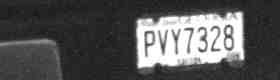

--------------------------------------------------
VRN:  BRF6466
Rekognition VRN:  BRE6466


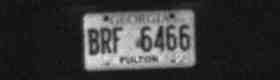

--------------------------------------------------
VRN:  BIR0457
Rekognition VRN:  BXR0457


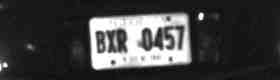

--------------------------------------------------
VRN:  CDC1462
Rekognition VRN:  CIC1462


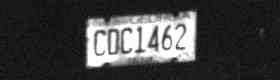

--------------------------------------------------
VRN:  CDA2242
Rekognition VRN:  COA2242


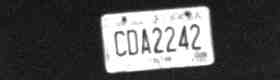

--------------------------------------------------
VRN:  BGU9437
Rekognition VRN:  BGU8437


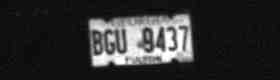

--------------------------------------------------
VRN:  29AV711
Rekognition VRN:  29AY711


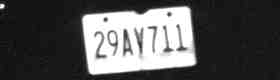

--------------------------------------------------
VRN:  PVZ5388
Rekognition VRN:  PZ5388


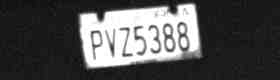

--------------------------------------------------
VRN:  PTF4754
Rekognition VRN:  PTFE4754


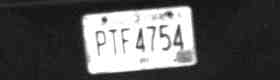

--------------------------------------------------
VRN:  CDF1428
Rekognition VRN:  COF1428


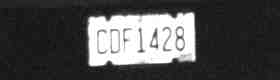

--------------------------------------------------
VRN:  CDP3904
Rekognition VRN:  COP3904


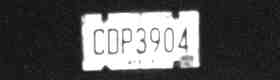

--------------------------------------------------
VRN:  QUALITY
Rekognition VRN:  QUALITYA


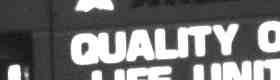

--------------------------------------------------
VRN:  8018AHT
Rekognition VRN:  8018AMT


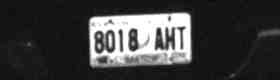

--------------------------------------------------
VRN:  BIX4820
Rekognition VRN:  BIY4820


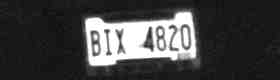

--------------------------------------------------
VRN:  CBK8367
Rekognition VRN:  LBK8367


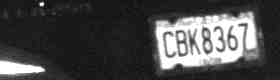

--------------------------------------------------
VRN:  AHH8792
Rekognition VRN:  SHH8792


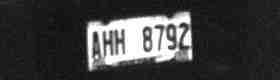

--------------------------------------------------
VRN:  CCZ3688
Rekognition VRN:  CTZ3688


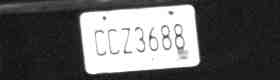

--------------------------------------------------
VRN:  PDA3479
Rekognition VRN:  POA3479


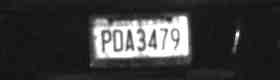

--------------------------------------------------
VRN:  PWY5877
Rekognition VRN:  PWY587Z


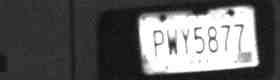

--------------------------------------------------
VRN:  QAB8599
Rekognition VRN:  0AB8599


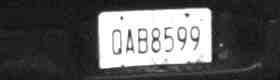

--------------------------------------------------
VRN:  CDF1933
Rekognition VRN:  COF1933


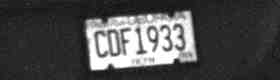

--------------------------------------------------
VRN:  BQA6778
Rekognition VRN:  BOA6778


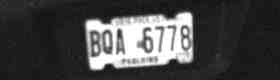

--------------------------------------------------
VRN:  CB05235
Rekognition VRN:  C805235


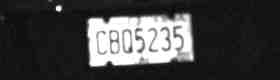

--------------------------------------------------
VRN:  CBG6968
Rekognition VRN:  C8G6968


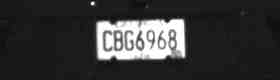

--------------------------------------------------
VRN:  AYS2886
Rekognition VRN:  AVS2886


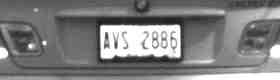

--------------------------------------------------
VRN:  PQG6269
Rekognition VRN:  P0G6269


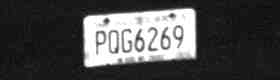

--------------------------------------------------
VRN:  CCA8520
Rekognition VRN:  CA8520


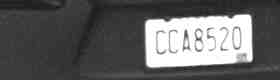

--------------------------------------------------
VRN:  BYI3318
Rekognition VRN:  BYT3318


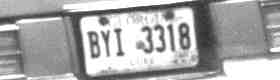

--------------------------------------------------
VRN:  GV18088
Rekognition VRN:  GVI8088


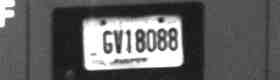

--------------------------------------------------
VRN:  PDG4815
Rekognition VRN:  P0G4815


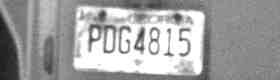

--------------------------------------------------
VRN:  43DH392
Rekognition VRN:  430H392


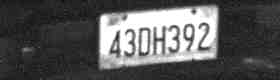

--------------------------------------------------
VRN:  BMW8443
Rekognition VRN:  BM8443


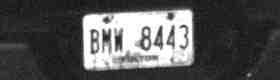

--------------------------------------------------
VRN:  BWS1253
Rekognition VRN:  BNS1253


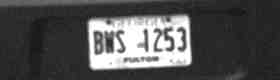

--------------------------------------------------
VRN:  CBN9912
Rekognition VRN:  CBN99112


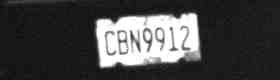

--------------------------------------------------
VRN:  TX10815
Rekognition VRN:  1X10815


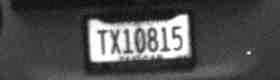

--------------------------------------------------
VRN:  PDB1938
Rekognition VRN:  P0B1938


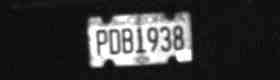

--------------------------------------------------
VRN:  6863ATK
Rekognition VRN:  6B63ATK


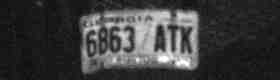

--------------------------------------------------
VRN:  1AF7289
Rekognition VRN:  AF7289


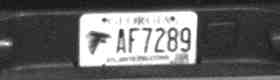

--------------------------------------------------
VRN:  BNT7689
Rekognition VRN:  BNT-7689


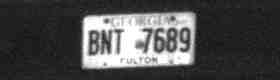

--------------------------------------------------
VRN:  PAB3009
Rekognition VRN:  PAB3000


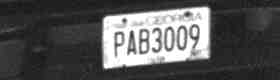

--------------------------------------------------
VRN:  PBB8722
Rekognition VRN:  P8B8722


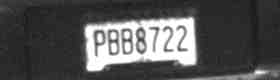

--------------------------------------------------
VRN:  BJZ7128
Rekognition VRN:  BJZ-7128


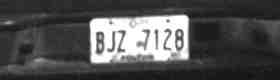

--------------------------------------------------
VRN:  PLB4013
Rekognition VRN:  PL84013


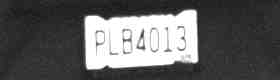

--------------------------------------------------
VRN:  PIZ7564
Rekognition VRN:  P1Z7564


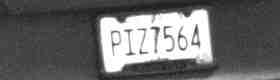

--------------------------------------------------
VRN:  PI09458
Rekognition VRN:  P109458


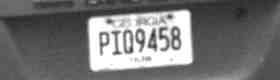

--------------------------------------------------
VRN:  PSB9864
Rekognition VRN:  P5B9864


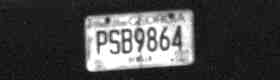

--------------------------------------------------
VRN:  PGB1775
Rekognition VRN:  PG81775


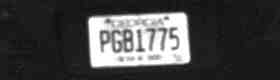

--------------------------------------------------
VRN:  PLG4941
Rekognition VRN:  PLG49A1


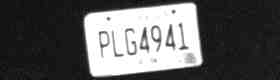

--------------------------------------------------
VRN:  PZZ6961
Rekognition VRN:  PZ6961


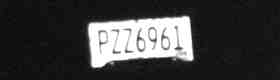

--------------------------------------------------
VRN:  AXL6641
Rekognition VRN:  AXL5641


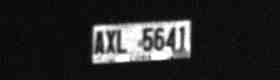

--------------------------------------------------
VRN:  CDF3461
Rekognition VRN:  COF3461


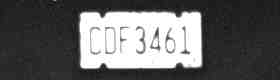

--------------------------------------------------
VRN:  BQF8343
Rekognition VRN:  BOF8343


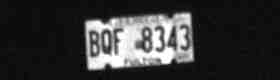

--------------------------------------------------
VRN:  PSE8984
Rekognition VRN:  P5E8984


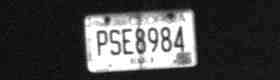

--------------------------------------------------
VRN:  BQA6778
Rekognition VRN:  BOA6778


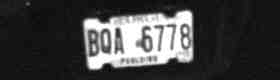

--------------------------------------------------
VRN:  CBZ6320
Rekognition VRN:  LBZ6320


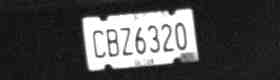

--------------------------------------------------
VRN:  PVY8368
Rekognition VRN:  PY8368


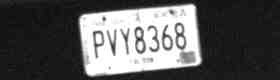

--------------------------------------------------
VRN:  BSV6100
Rekognition VRN:  BSV5100


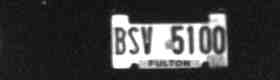

--------------------------------------------------
VRN:  CBE9618
Rekognition VRN:  C8E9618


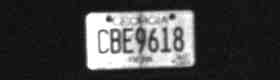

--------------------------------------------------
VRN:  ARQ9056
Rekognition VRN:  ARO9056


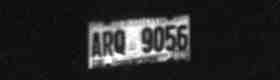

--------------------------------------------------
VRN:  IMT1254
Rekognition VRN:  IMT254


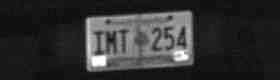

--------------------------------------------------
VRN:  2275AEW
Rekognition VRN:  2275AEM


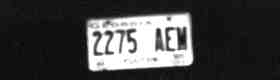

--------------------------------------------------
VRN:  PZZ6961
Rekognition VRN:  P2Z6961


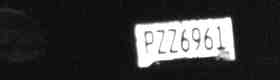

--------------------------------------------------
VRN:  PFB4653
Rekognition VRN:  PFB4652


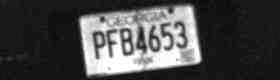

--------------------------------------------------
VRN:  PDB1938
Rekognition VRN:  PB1938


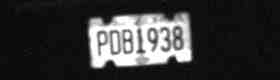

--------------------------------------------------
VRN:  8018AHT
Rekognition VRN:  8018AMT


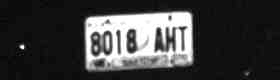

--------------------------------------------------
VRN:  PHG3277
Rekognition VRN:  PH63277


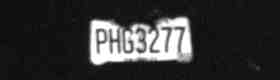

--------------------------------------------------
VRN:  AHW3237
Rekognition VRN:  AHN3237


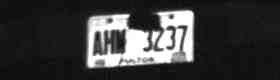

--------------------------------------------------
VRN:  CALIRSD
Rekognition VRN:  TALIRSD


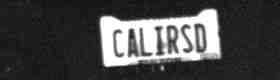

--------------------------------------------------
VRN:  PFC0358
Rekognition VRN:  PFCO358


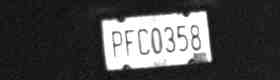

--------------------------------------------------
VRN:  PFB1346
Rekognition VRN:  PFBI346


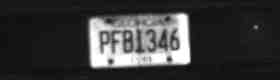

--------------------------------------------------
VRN:  PGZ1157
Rekognition VRN:  P6Z1157


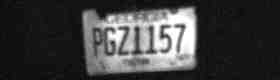

--------------------------------------------------
VRN:  BMG9405
Rekognition VRN:  BNG9405


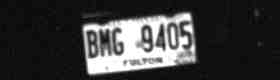

--------------------------------------------------
VRN:  MTLW452
Rekognition VRN:  TLW452


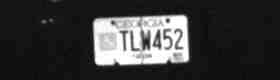

--------------------------------------------------
VRN:  PAA2409
Rekognition VRN:  PAA2400


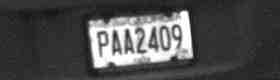

--------------------------------------------------
VRN:  PMC8087
Rekognition VRN:  PNC8087


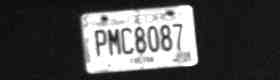

--------------------------------------------------
VRN:  PNQ1176
Rekognition VRN:  PN01176


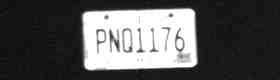

--------------------------------------------------
VRN:  PJF8420
Rekognition VRN:  PJF8420D


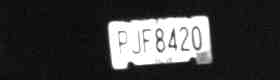

--------------------------------------------------
VRN:  CBE1585
Rekognition VRN:  TBE1585


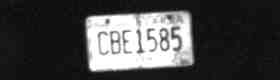

--------------------------------------------------
VRN:  PJM9413
Rekognition VRN:  PIM9413


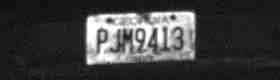

--------------------------------------------------
VRN:  BQG0244
Rekognition VRN:  BOG0244


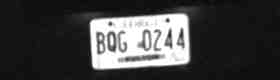

--------------------------------------------------
VRN:  AAZ1390
Rekognition VRN:  ANZ1390


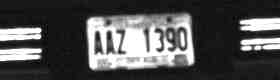

--------------------------------------------------
VRN:  CBZ6320
Rekognition VRN:  LBZ6320


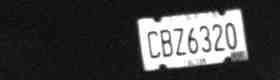

--------------------------------------------------
VRN:  CDC6386
Rekognition VRN:  COC6386


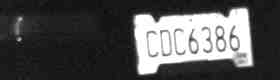

--------------------------------------------------
VRN:  AGV6998
Rekognition VRN:  AGY6998


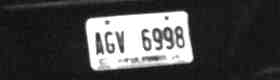

--------------------------------------------------
VRN:  AFK1689
Rekognition VRN:  AHK1689


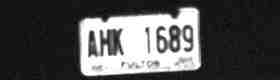

--------------------------------------------------
VRN:  CCC3138
Rekognition VRN:  LCC3138


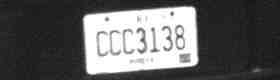

--------------------------------------------------
VRN:  AZD7966
Rekognition VRN:  AZD-7966


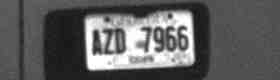

--------------------------------------------------
VRN:  PAC0394
Rekognition VRN:  PACO394


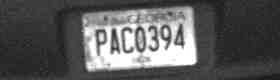

--------------------------------------------------
VRN:  VHU6464
Rekognition VRN:  HU6464


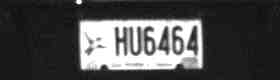

--------------------------------------------------
VRN:  AHS9776
Rekognition VRN:  AWS9776


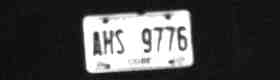

--------------------------------------------------
VRN:  AMX2561
Rekognition VRN:  ANX2561


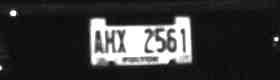

--------------------------------------------------
VRN:  PYW8543
Rekognition VRN:  PYW8542


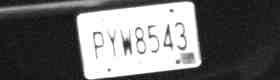

--------------------------------------------------
VRN:  CBX7974
Rekognition VRN:  C8X7974


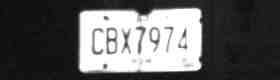

--------------------------------------------------
VRN:  8018AHT
Rekognition VRN:  8018AMT


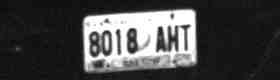

--------------------------------------------------
VRN:  CDR5542
Rekognition VRN:  LDR5542


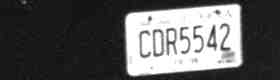

--------------------------------------------------
VRN:  AZK6634
Rekognition VRN:  AZK5634


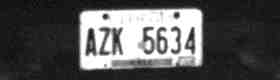

--------------------------------------------------
VRN:  CAY9621
Rekognition VRN:  CAy9621


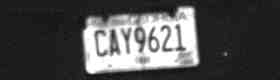

--------------------------------------------------
VRN:  PEJ2310
Rekognition VRN:  FEJ2310


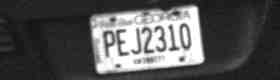

--------------------------------------------------
VRN:  CBW1694
Rekognition VRN:  LBW1694


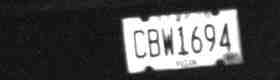

--------------------------------------------------
VRN:  PFS9889
Rekognition VRN:  PF99889


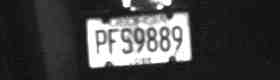

--------------------------------------------------
VRN:  PIQ9458
Rekognition VRN:  PI09458


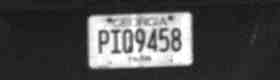

--------------------------------------------------
VRN:  CCC8306
Rekognition VRN:  CC8306


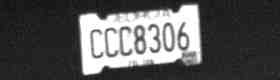

--------------------------------------------------
VRN:  BGU9437
Rekognition VRN:  BGU8437


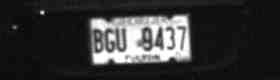

--------------------------------------------------
VRN:  BSI6721
Rekognition VRN:  BST6721


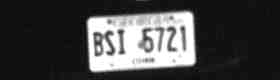

--------------------------------------------------
VRN:  BBP3294
Rekognition VRN:  BBP329


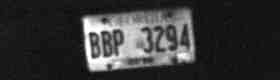

--------------------------------------------------
VRN:  PCC3329
Rekognition VRN:  PCC3320


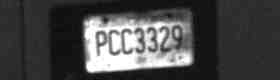

--------------------------------------------------
VRN:  BMW6032
Rekognition VRN:  BMM6032


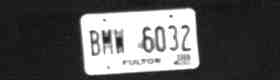

--------------------------------------------------
VRN:  PFC0781
Rekognition VRN:  PFCO781


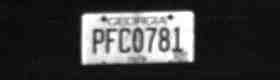

--------------------------------------------------
VRN:  PKN1754
Rekognition VRN:  PKN175


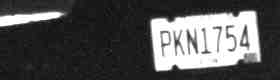

--------------------------------------------------
VRN:  BZI9676
Rekognition VRN:  BZ19676


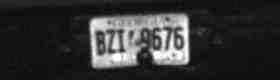

--------------------------------------------------
VRN:  PSE8984
Rekognition VRN:  PE8984


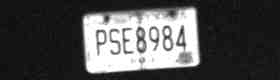

--------------------------------------------------
VRN:  PHP3013
Rekognition VRN:  PHP301


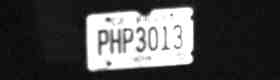

--------------------------------------------------
VRN:  BQH7357
Rekognition VRN:  BOH7357


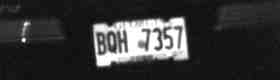

--------------------------------------------------
VRN:  BQX4111
Rekognition VRN:  BQX1111


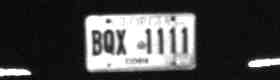

--------------------------------------------------
VRN:  PHC8084
Rekognition VRN:  HC8084


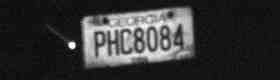

--------------------------------------------------
VRN:  CBX7974
Rekognition VRN:  CEX7974


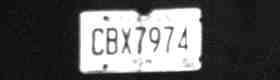

--------------------------------------------------
VRN:  PVL1214
Rekognition VRN:  PVL1214A


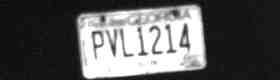

--------------------------------------------------
VRN:  BLW8684
Rekognition VRN:  BL8684


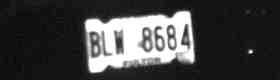

--------------------------------------------------
VRN:  PLI6443
Rekognition VRN:  PL16443


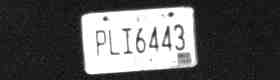

--------------------------------------------------
VRN:  BPE7451
Rekognition VRN:  BPE-7451


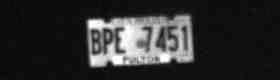

--------------------------------------------------
VRN:  AXL6641
Rekognition VRN:  AXL5641


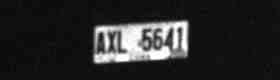

--------------------------------------------------
VRN:  BPS1714
Rekognition VRN:  BPS714


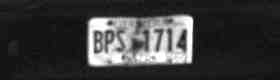

--------------------------------------------------
VRN:  PLQ8328
Rekognition VRN:  PL08328


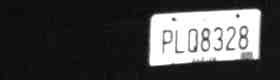

--------------------------------------------------
VRN:  PSB9864
Rekognition VRN:  P5B9864


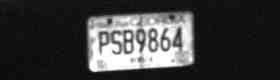

--------------------------------------------------
VRN:  AJG8040
Rekognition VRN:  4JG8040


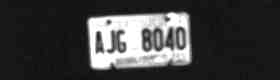

--------------------------------------------------
VRN:  CCC3138
Rekognition VRN:  LCC3138


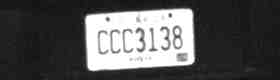

--------------------------------------------------
VRN:  CBU2391
Rekognition VRN:  LBU2391


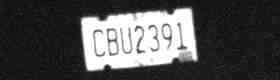

--------------------------------------------------
VRN:  PAA2409
Rekognition VRN:  PAA2400


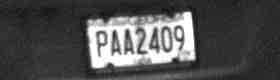

--------------------------------------------------
VRN:  BQD0031
Rekognition VRN:  BD0031


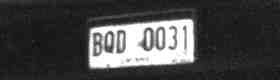

--------------------------------------------------
VRN:  PCQ1064
Rekognition VRN:  PC01064


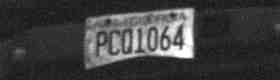

--------------------------------------------------
VRN:  PVA9609
Rekognition VRN:  PVA9600


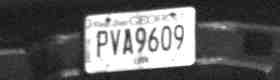

--------------------------------------------------
VRN:  FYTNESS
Rekognition VRN:  FYINESS


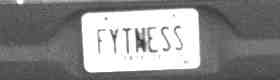

--------------------------------------------------
VRN:  PLJ1851
Rekognition VRN:  PJ1851


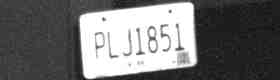

--------------------------------------------------
VRN:  PKQ7045
Rekognition VRN:  PK07045


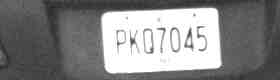

--------------------------------------------------
VRN:  PCU4253
Rekognition VRN:  PCU4252


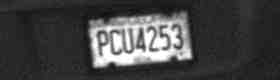

--------------------------------------------------
VRN:  CBG6968
Rekognition VRN:  LBG6968


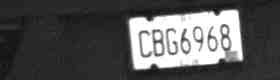

--------------------------------------------------
VRN:  PKS5189
Rekognition VRN:  PKS5180


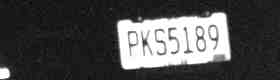

--------------------------------------------------
VRN:  PQT4446
Rekognition VRN:  POT4446


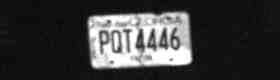

--------------------------------------------------
VRN:  BGI4614
Rekognition VRN:  BGI.4614


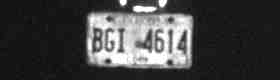

--------------------------------------------------
VRN:  BMB6867
Rekognition VRN:  BMNB6867


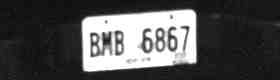

--------------------------------------------------
VRN:  PJQ8965
Rekognition VRN:  PJ08965


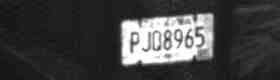

--------------------------------------------------
VRN:  BQA6778
Rekognition VRN:  BOA6778


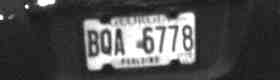

--------------------------------------------------
VRN:  PTV2690
Rekognition VRN:  PTY2690


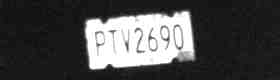

--------------------------------------------------
VRN:  PKU5138
Rekognition VRN:  PKU538


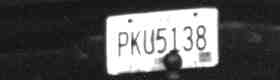

--------------------------------------------------
VRN:  PBD9165
Rekognition VRN:  P8D9165


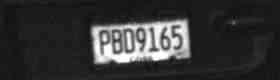

--------------------------------------------------
VRN:  CBK6972
Rekognition VRN:  LBK6972


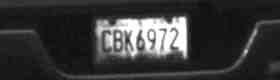

--------------------------------------------------
VRN:  PHS8480
Rekognition VRN:  PH58480


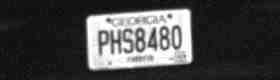

--------------------------------------------------
VRN:  PJY3205
Rekognition VRN:  JY3205


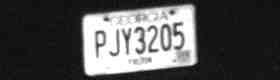

--------------------------------------------------
VRN:  BEP0229
Rekognition VRN:  BCP0229


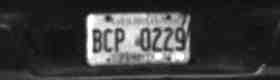

--------------------------------------------------
VRN:  CDG6250
Rekognition VRN:  C0G6250


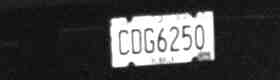

--------------------------------------------------
VRN:  ABG3352
Rekognition VRN:  IBG3352


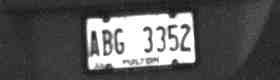

--------------------------------------------------
VRN:  AMT7086
Rekognition VRN:  AHT7086


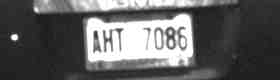

--------------------------------------------------
VRN:  CDF3461
Rekognition VRN:  COF3461


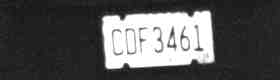

--------------------------------------------------
VRN:  BQF8343
Rekognition VRN:  BOF8343


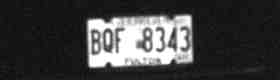

--------------------------------------------------
VRN:  PIN2093
Rekognition VRN:  PIN2092


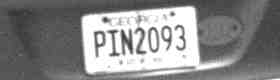

--------------------------------------------------
VRN:  CBU7110
Rekognition VRN:  CBU711


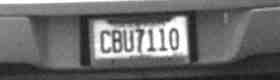

--------------------------------------------------
VRN:  AAM7670
Rekognition VRN:  AAN7670


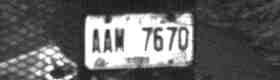

--------------------------------------------------
VRN:  PRM4562
Rekognition VRN:  PRn4562


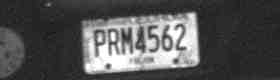

--------------------------------------------------
VRN:  CBU6551
Rekognition VRN:  BU6551


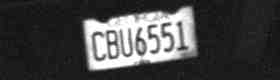

--------------------------------------------------
VRN:  AEX1024
Rekognition VRN:  AEY1024


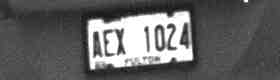

--------------------------------------------------
VRN:  TL6V369
Rekognition VRN:  TL61369


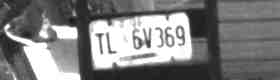

--------------------------------------------------
VRN:  AUD3740
Rekognition VRN:  AUD740


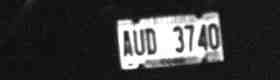

--------------------------------------------------
VRN:  CBV8203
Rekognition VRN:  LBV8203


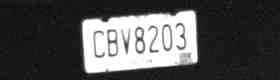

--------------------------------------------------
VRN:  PEK6979
Rekognition VRN:  PEK6970


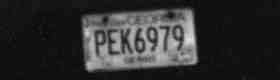

--------------------------------------------------
VRN:  CDP3904
Rekognition VRN:  TDP3904


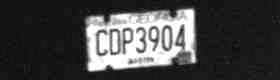

--------------------------------------------------
VRN:  CCA8520
Rekognition VRN:  LCA8520


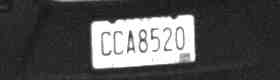

--------------------------------------------------
VRN:  PTV9053
Rekognition VRN:  PTV3053


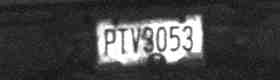

--------------------------------------------------
VRN:  BIQ9375
Rekognition VRN:  BIO9375


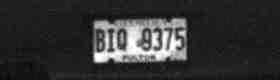

--------------------------------------------------
VRN:  PXL6068
Rekognition VRN:  XL6068


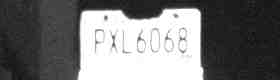

--------------------------------------------------
VRN:  CBQ4031
Rekognition VRN:  CB04031


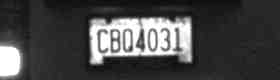

--------------------------------------------------
VRN:  CCE3062
Rekognition VRN:  LCE3062


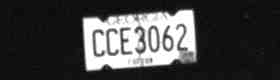

--------------------------------------------------
VRN:  PBA5815
Rekognition VRN:  P8A5815


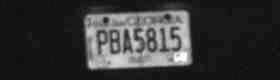

--------------------------------------------------
VRN:  AYY6422
Rekognition VRN:  AYY5422


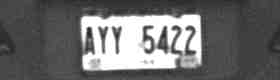

--------------------------------------------------
VRN:  BMW6032
Rekognition VRN:  BM6032


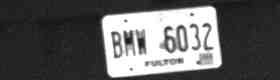

--------------------------------------------------
VRN:  CCD1458
Rekognition VRN:  CCO1458


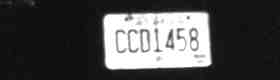

--------------------------------------------------
VRN:  BQG0279
Rekognition VRN:  BOG0279


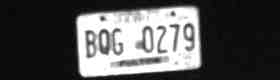

--------------------------------------------------
VRN:  CBQ5235
Rekognition VRN:  CB05235


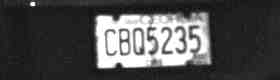

--------------------------------------------------
VRN:  AFP2997
Rekognition VRN:  AFP997


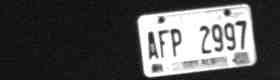

--------------------------------------------------
VRN:  PMZ9915
Rekognition VRN:  PHZ9915


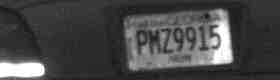

--------------------------------------------------
VRN:  AHK1689
Rekognition VRN:  AHK689


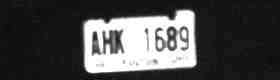

--------------------------------------------------
VRN:  POG3763
Rekognition VRN:  PQG3763


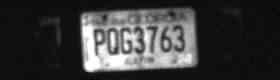

--------------------------------------------------
VRN:  PDG2472
Rekognition VRN:  PIG2472


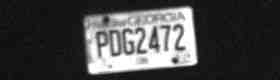

--------------------------------------------------
VRN:  AHP7615
Rekognition VRN:  AMP7615


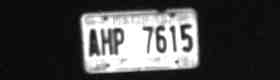

--------------------------------------------------
VRN:  PTV2850
Rekognition VRN:  P7V2850


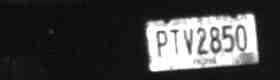

--------------------------------------------------
VRN:  PDN2602
Rekognition VRN:  PIN2602


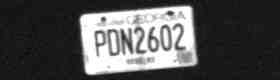

--------------------------------------------------
VRN:  PGA8754
Rekognition VRN:  GA8754


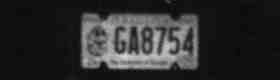

--------------------------------------------------
VRN:  0083AL2
Rekognition VRN:  0083A12


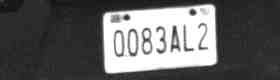

--------------------------------------------------
VRN:  PQT8145
Rekognition VRN:  P0T8145


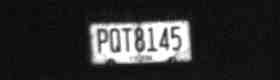

--------------------------------------------------
VRN:  PVA9609
Rekognition VRN:  PVA9600


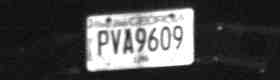

--------------------------------------------------
VRN:  BGWILLY
Rekognition VRN:  BGKILLY


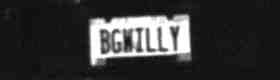

--------------------------------------------------
VRN:  wDP2GC4
Rekognition VRN:  DP2GC4


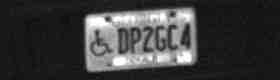

--------------------------------------------------
VRN:  CDH8992
Rekognition VRN:  COH8992


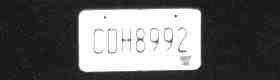

--------------------------------------------------
VRN:  PIQ9458
Rekognition VRN:  PI09458


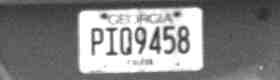

--------------------------------------------------
VRN:  API1916
Rekognition VRN:  APX1916


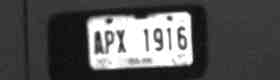

--------------------------------------------------
VRN:  PDD4262
Rekognition VRN:  P0D4262


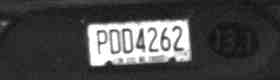

--------------------------------------------------
VRN:  PCV7099
Rekognition VRN:  PCV7O99


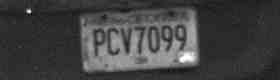

--------------------------------------------------
VRN:  0RT7508
Rekognition VRN:  ORT7508


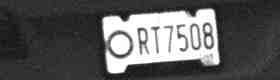

--------------------------------------------------
VRN:  BQF8343
Rekognition VRN:  BoF8343


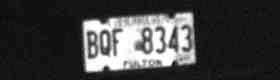

--------------------------------------------------
VRN:  PJC2242
Rekognition VRN:  DJC2242


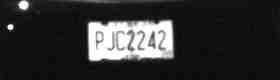

--------------------------------------------------
VRN:  PQW9957
Rekognition VRN:  POW9957


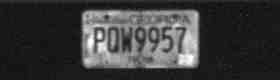

--------------------------------------------------
VRN:  PVD7579
Rekognition VRN:  PVD7570


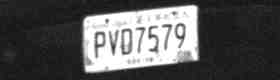

--------------------------------------------------
VRN:  AHS5950
Rekognition VRN:  AS5950


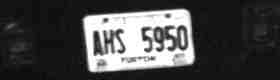

--------------------------------------------------
VRN:  CDF3461
Rekognition VRN:  COF3461


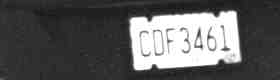

--------------------------------------------------
VRN:  PKU5138
Rekognition VRN:  PKU538


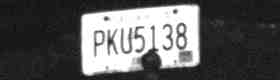

--------------------------------------------------
VRN:  PJY4A74
Rekognition VRN:  PJY4074


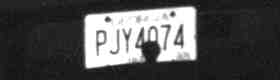

--------------------------------------------------
VRN:  CCC2387
Rekognition VRN:  TCC2387


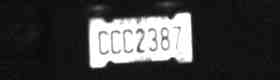

--------------------------------------------------
VRN:  PDG2472
Rekognition VRN:  PIG2472


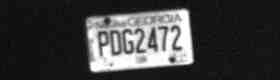

--------------------------------------------------
VRN:  AWL6884
Rekognition VRN:  AML6884


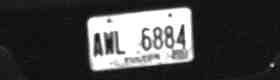

--------------------------------------------------
VRN:  AUW5419
Rekognition VRN:  AUK5419


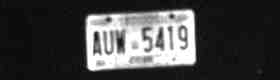

--------------------------------------------------
VRN:  BXI7320
Rekognition VRN:  BXI-7320


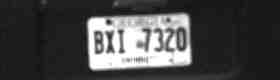

--------------------------------------------------
VRN:  BJB6129
Rekognition VRN:  BJB5129


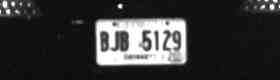

--------------------------------------------------
VRN:  AZB6339
Rekognition VRN:  AZB5339


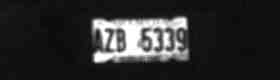

--------------------------------------------------
VRN:  PVY8368
Rekognition VRN:  PYY8368


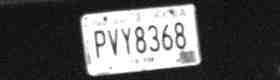

--------------------------------------------------
VRN:  BML1929
Rekognition VRN:  BML929


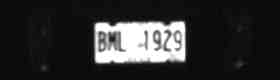

--------------------------------------------------
VRN:  BRQ0010
Rekognition VRN:  BRO0010


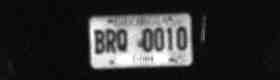

--------------------------------------------------
VRN:  8018AHT
Rekognition VRN:  8018AMT


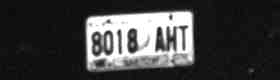

--------------------------------------------------
VRN:  BLW8684
Rekognition VRN:  BLW868A


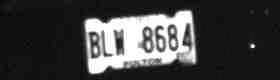

--------------------------------------------------
VRN:  AXL6641
Rekognition VRN:  AXL5641


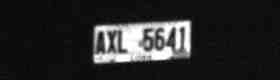

--------------------------------------------------
VRN:  BIQ3230
Rekognition VRN:  BXQ3230


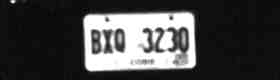

--------------------------------------------------
VRN:  PHI6448
Rekognition VRN:  PH16448


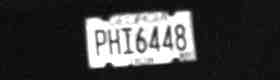

--------------------------------------------------
VRN:  CAT5563
Rekognition VRN:  TAT5563


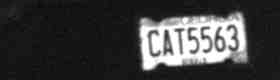

--------------------------------------------------
VRN:  AHW7552
Rekognition VRN:  AHN7552


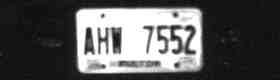

--------------------------------------------------
VRN:  2275AEW
Rekognition VRN:  2275AEM


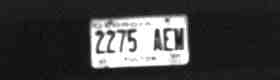

--------------------------------------------------
VRN:  PKN2800
Rekognition VRN:  PN2800


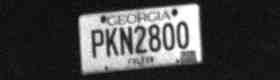

--------------------------------------------------
VRN:  FAF6651
Rekognition VRN:  AF6651


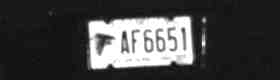

--------------------------------------------------
VRN:  1DKB944
Rekognition VRN:  DKB944


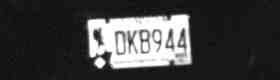

--------------------------------------------------
VRN:  BJX2463
Rekognition VRN:  BJY2463


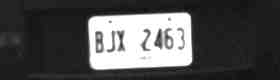

--------------------------------------------------
VRN:  BMV8142
Rekognition VRN:  BNV8142


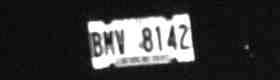

--------------------------------------------------
VRN:  BMV6279
Rekognition VRN:  BNV6279


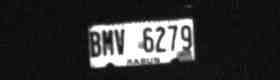

--------------------------------------------------
VRN:  CDP3904
Rekognition VRN:  COP3904


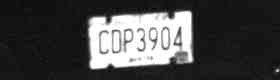

--------------------------------------------------
VRN:  PTC2559
Rekognition VRN:  PIC2559


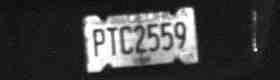

--------------------------------------------------
VRN:  PQT4446
Rekognition VRN:  POT4446


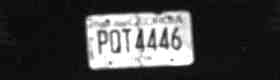

--------------------------------------------------
VRN:  CCB5703
Rekognition VRN:  CC85703


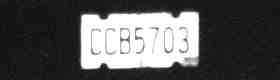

--------------------------------------------------
VRN:  TL0LZ97
Rekognition VRN:  TLOLZ97


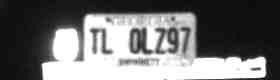

--------------------------------------------------
VRN:  PTI6129
Rekognition VRN:  PTI6120


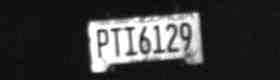

--------------------------------------------------
VRN:  55AJ272
Rekognition VRN:  55A3272


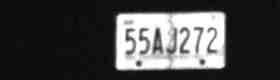

--------------------------------------------------
VRN:  CBB9516
Rekognition VRN:  CB89516


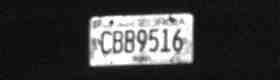

--------------------------------------------------
VRN:  BTQ5208
Rekognition VRN:  BTO5208


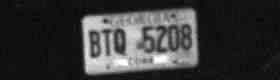

--------------------------------------------------
VRN:  CDL9853
Rekognition VRN:  C0L9853


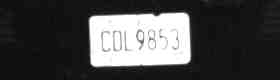

--------------------------------------------------
VRN:  PZZ6961
Rekognition VRN:  PLZ6961


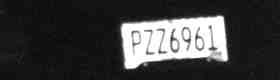

--------------------------------------------------
VRN:  BNQ2661
Rekognition VRN:  BNQ266


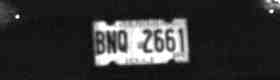

--------------------------------------------------
VRN:  PDB1938
Rekognition VRN:  POB1938


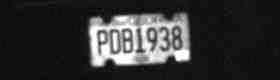

--------------------------------------------------
VRN:  PZS3982
Rekognition VRN:  PZ53982


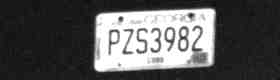

--------------------------------------------------
VRN:  CCZ5613
Rekognition VRN:  CIZ5613


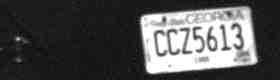

--------------------------------------------------
VRN:  BQS9828
Rekognition VRN:  BOS9828


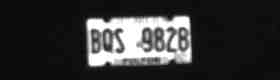

--------------------------------------------------
VRN:  CCR1061
Rekognition VRN:  CER1061


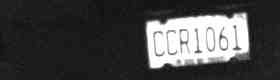

--------------------------------------------------
VRN:  PKN1999
Rekognition VRN:  PKN1990


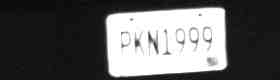

--------------------------------------------------
VRN:  BUE1615
Rekognition VRN:  BUE-1615


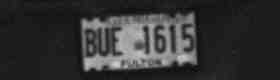

--------------------------------------------------
VRN:  BGU9437
Rekognition VRN:  BGU8437


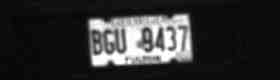

--------------------------------------------------
VRN:  PIQ9458
Rekognition VRN:  PI09458


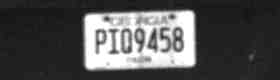

--------------------------------------------------
VRN:  PWN1732
Rekognition VRN:  PWN1Z32


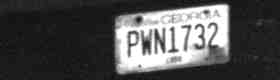

--------------------------------------------------
VRN:  PFF9889
Rekognition VRN:  PFF9880


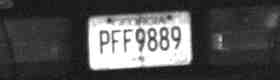

--------------------------------------------------
VRN:  FPAI9489
Rekognition VRN:  PAI9489


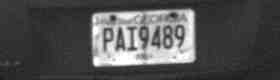

--------------------------------------------------
VRN:  FPQT5894
Rekognition VRN:  PQT5894


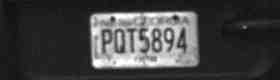

--------------------------------------------------


In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
for i in range(len(df_unmatched)):
    print('VRN: ', df_unmatched.VRN[i])
    print('Rekognition VRN: ', df_unmatched.Rekognition_VRN[i])
    display(Image(jp(DATAPATH, df_unmatched.IRImagePatch[i])))
    print('-----'*10)

VRN:  0SJ1001
Rekognition VRN:  OSJ100


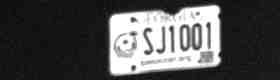

--------------------------------------------------
VRN:  0SJ1001
Rekognition VRN:  2


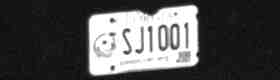

--------------------------------------------------
VRN:  0SJ1001
Rekognition VRN:  OSJ10O1


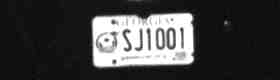

--------------------------------------------------


In [150]:
# special case: some VRNs with different output
for i in range(len(df[df.VRN=='0SJ1001'].reset_index())):
    print('VRN: ', df[df.VRN=='0SJ1001'].reset_index().VRN[i])
    print('Rekognition VRN: ', df[df.VRN=='0SJ1001'].reset_index().Rekognition_VRN[i])
    display(Image(jp(DATAPATH, df[df.VRN=='0SJ1001'].reset_index().IRImagePatch[i])))
    print('-----'*10)